# <center>Application of Time Series Forecasting in Real Estate Valuation </center>
## <center> Notebook 3: Mean-Point Time Series Modeling</center>


### Notebook Content:

<a href='#Destination_1'>1. Import Libraries</a><br>

<a href='#Destination_2'>2. Import Data</a>

<a href='#Destination_3'>3. Create Time Series Data </a><br>

<a href='#Destination_4'>4. Time Series Models</a><br>
- <a href='#Destination_4.1'>4.1 Baseline Models: ARIMAX & SARIMAX</a>
 - <a href='#Destination_4.1.1'>4.1.1 Exploratory Data Analysis (EDA)</a>
 - <a href='#Destination_4.1.2'>4.1.2 Train Sample X</a>
 - <a href='#Destination_4.1.3'>4.1.3 Train for All possible X</a>



-  <a href='#Destination_4.2'>4.2 Proposed Model: LSTM</a>
 - <a href='#Destination_4.2.1'>4.2.1 Train Sample X</a>
 - <a href='#Destination_4.2.2'>4.2.2 Train for All possible X</a>

<a href='#Destination_5'>5. Plot Time Series Models Results</a><br>


#### The approach in a nutshell
The pipepline is built to take an instance X, and produce a time series that best represent X. The time series is then forecasted using baseline models and an LSTM model. The catch in this approach is that the time series produced does not come from model predictions (as in the approach in notebook 2), rather it is produced by sampling from the full dataset based on certain criteria. 

<a id='Destination_1'></a>
# Import Libraries:

In [ ]:
import numpy as np
import pandas as pd
import itertools
import plotly.express as px

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.preprocessing import normalize,StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import (CutoffSplitter,SlidingWindowSplitter,temporal_train_test_split)
from sktime.utils.plotting import plot_series

from sklego.model_selection import TimeGapSplit

import pmdarima as pm
from pmdarima.arima import auto_arima


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from warnings import catch_warnings
from warnings import filterwarnings


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
np.random.seed(2022)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 1000)

<a id='Destination_2'></a>

# Import Data


In [ ]:
df = pd.read_csv('./Data_Frame.csv') .drop('DistrictName',axis=1)
display(df.head())
df.shape

,TradePrice,Area,MinTimeToNearestStation,HousingCPI,DistrictAvgPriceByQuarter,CityPlanningAvgPriceByQuarter,AreaAvgPriceByQuarter,MinTimeAvgPriceByQuarter,Year,Quarter,Type,CityPlanning
0,40000000,30,4.000,99.800,32000000.000,32677745.665,25908955.224,34799641.577,2019,3,"Pre-owned Condominiums, etc.",Commercial Zone
1,24000000,35,3.000,99.600,39000000.000,32048355.755,27864705.882,36263800.905,2018,4,"Pre-owned Condominiums, etc.",Commercial Zone
2,13000000,20,4.000,99.600,19333333.333,32997092.084,20234039.548,37631818.182,2018,3,"Pre-owned Condominiums, etc.",Commercial Zone
3,22000000,30,3.000,99.600,48250000.000,33501250.977,27105357.143,35733333.333,2018,2,"Pre-owned Condominiums, etc.",Commercial Zone
4,69000000,70,1.000,99.600,48250000.000,33501250.977,45493857.494,35166137.566,2018,2,"Pre-owned Condominiums, etc.",Commercial Zone


(328612, 12)

<a id='Destination_3'></a>


# Create Time Series Data

<p>This function takes an input sample X that the user wants to investigate and produces a time series that represent the sample X. The representation is based on simileraties between the discrete features of X and the area group of X with available data.</p>

Area Group: 
the set of instances that lie within <b>[Area of X - 5, Area of X + 5]</b>

The function works the following:
1. Sample from the dataset instances with the same <b>[Type, CityPlanning, Area group]</b> 
2. Produce the mean point representative instance for X in evey quarter 
3. returns a time series of representative instances for X


In [ ]:
def create_timeseries(df,x):
    
    # find the set of instances with the same (Type, CityPlanning, Area Group) as the instance x
    df = df.loc[df['TradePrice']<=1e8].loc[df['MinTimeToNearestStation']<=25]
    cols = list(df)
    df_x = df.loc[df['Type']==x['Type']].loc[df['CityPlanning']==x['CityPlanning']].loc[
        df['Area']<=x['Area']+5].loc[df['Area']>=x['Area']-5].reset_index(drop=True)
    df_x = df_x.drop('CityPlanning',axis=1).drop('Type',axis=1)
    
    #if the set is not empty
    if df_x.shape[0]!=0:
   
        # initialize the time series 
        time_series = pd.DataFrame(columns =list(df_x))
        for year in np.sort(df_x['Year'].unique()):
            
            # locate instances in that specific "year"
            temp_df = df_x.loc[df_x['Year'] == year]

            for Q in np.sort(temp_df['Quarter'].unique()):

                # locate instances in that specific "quarter"
                temp_df_2 = temp_df.loc[temp_df['Quarter'] == Q]
                
                # if the set is not empty
                if temp_df_2.shape[0]!=0:
                   
                    # get the mean of the continues features 
                    mean_values = temp_df_2.values[:,0:8].mean(axis=0) # the last two features "year" & "quarter" are excluded, because they will be used as Timestamp
                  
                    # Concatenate the mean values with Timestamp
                    s = np.concatenate((mean_values,[year,Q]),axis=0)
                  
                    # create a temporary dataframe for the mean point "s"  
                    append_df = pd.DataFrame(np.reshape(s,(1,10)),columns=list(df_x))
                  
                    # add the mean point s to the time series
                    time_series =  pd.concat([time_series,append_df],axis=0)
        
        # to check if the size of the time series is too small
        if time_series.shape[0]<30:
            return 0
        else:
            # Reformat the time series dataframe

            time_series = time_series.reset_index(drop=True)
            time_series.loc[:,cols[0:8]] = time_series[cols[0:8]].astype(float)
            time_series[['Year','Quarter']] = time_series[['Year','Quarter']].astype(int)
            time_series['Date'] = [time_series['Year'][i].astype(str)+'-Q'
                               +time_series['Quarter'][i].astype(str) for i in range(time_series.shape[0])]
            time_series = time_series.drop('Year',axis=1).drop('Quarter',axis=1)

            return time_series
        
    # else the set is empty    
    else: 
        return 0



<a id='Destination_4'></a>


# Time Series Models

Two approaches introduced in this work:
1. The Baseline Models: ARIMAX and SARIMAX Models
2. The Proposed Model: LSTM Model

<a id='Destination_4.1'></a>


# Baseline Models

The baseline model is a simple model with good performance. Used as an indication to what is the minimum expected performance for our data and compare it with the Proposed model LSTM. 

Two baseline models:

<b>- ARIMAX</b><br>
<b>- SARIMAX</b>



<a id='Destination_4.1.1'></a>


## Exploratory Data Analysis (EDA) For Baseline Models

Understand and Analysis the data using statistics and graphical representations.

EDA tasks done to investagete:
1. The pattern of <b>Tradeprice</b> 
2. The four component<b> Pattern, trend, Seasonality, and noise </b>from the data using decomposition
3. The stationary of the data with ADF test and rolling mean
4. <b>P</b> and <b>Q </b>parameters lags order with PACF and ACF  plot

### Example Case
This section to demonstrate the pipeline process for any given instance X.

In [ ]:
# get the df columns name
columnsName = list(df)

#get an example instance
x = df.loc[0,columnsName[1:]]
display(x)

# use mean point scheme to create time series based sample X
time_series = create_timeseries(df,x)
display(time_series.head())
time_series.shape

Area                                                       30
MinTimeToNearestStation                                 4.000
HousingCPI                                             99.800
DistrictAvgPriceByQuarter                        32000000.000
CityPlanningAvgPriceByQuarter                    32677745.665
AreaAvgPriceByQuarter                            25908955.224
MinTimeAvgPriceByQuarter                         34799641.577
Year                                                     2019
Quarter                                                     3
Type                             Pre-owned Condominiums, etc.
CityPlanning                                  Commercial Zone
Name: 0, dtype: object

,TradePrice,Area,MinTimeToNearestStation,HousingCPI,DistrictAvgPriceByQuarter,CityPlanningAvgPriceByQuarter,AreaAvgPriceByQuarter,MinTimeAvgPriceByQuarter,Date
0,19480722.892,28.855,5.169,101.433,27078776.371,28066789.668,17813664.388,34300290.843,2005-Q3
1,22070103.093,28.918,4.577,101.533,29994473.921,29202941.176,19239071.913,34430899.599,2005-Q4
2,21507176.471,29.647,3.659,101.600,30727274.999,29725697.211,19077757.182,36580400.120,2006-Q1
3,20024193.548,28.065,4.484,101.567,27295884.487,30210772.834,18585398.338,37500829.524,2006-Q2
4,19429508.197,29.426,4.262,101.400,30757906.208,29821002.387,18958598.193,37127886.034,2006-Q3


(57, 9)

In [ ]:
# For EDA set the "Date" column as an index
time_series['Date']=pd.to_datetime(time_series['Date'])
time_series=time_series.apply(pd.to_numeric)
time_series['Date']=pd.to_datetime(time_series['Date'])
time_seriesdate=time_series.set_index('Date')
time_seriesdate.head()


,TradePrice,Area,MinTimeToNearestStation,HousingCPI,DistrictAvgPriceByQuarter,CityPlanningAvgPriceByQuarter,AreaAvgPriceByQuarter,MinTimeAvgPriceByQuarter
Date,,,,,,,,
2005-07-01,19480722.892,28.855,5.169,101.433,27078776.371,28066789.668,17813664.388,34300290.843
2005-10-01,22070103.093,28.918,4.577,101.533,29994473.921,29202941.176,19239071.913,34430899.599
2006-01-01,21507176.471,29.647,3.659,101.600,30727274.999,29725697.211,19077757.182,36580400.120
2006-04-01,20024193.548,28.065,4.484,101.567,27295884.487,30210772.834,18585398.338,37500829.524
2006-07-01,19429508.197,29.426,4.262,101.400,30757906.208,29821002.387,18958598.193,37127886.034


### Plot the TradePrice for a Sample of X

<function matplotlib.pyplot.show(close=None, block=None)>

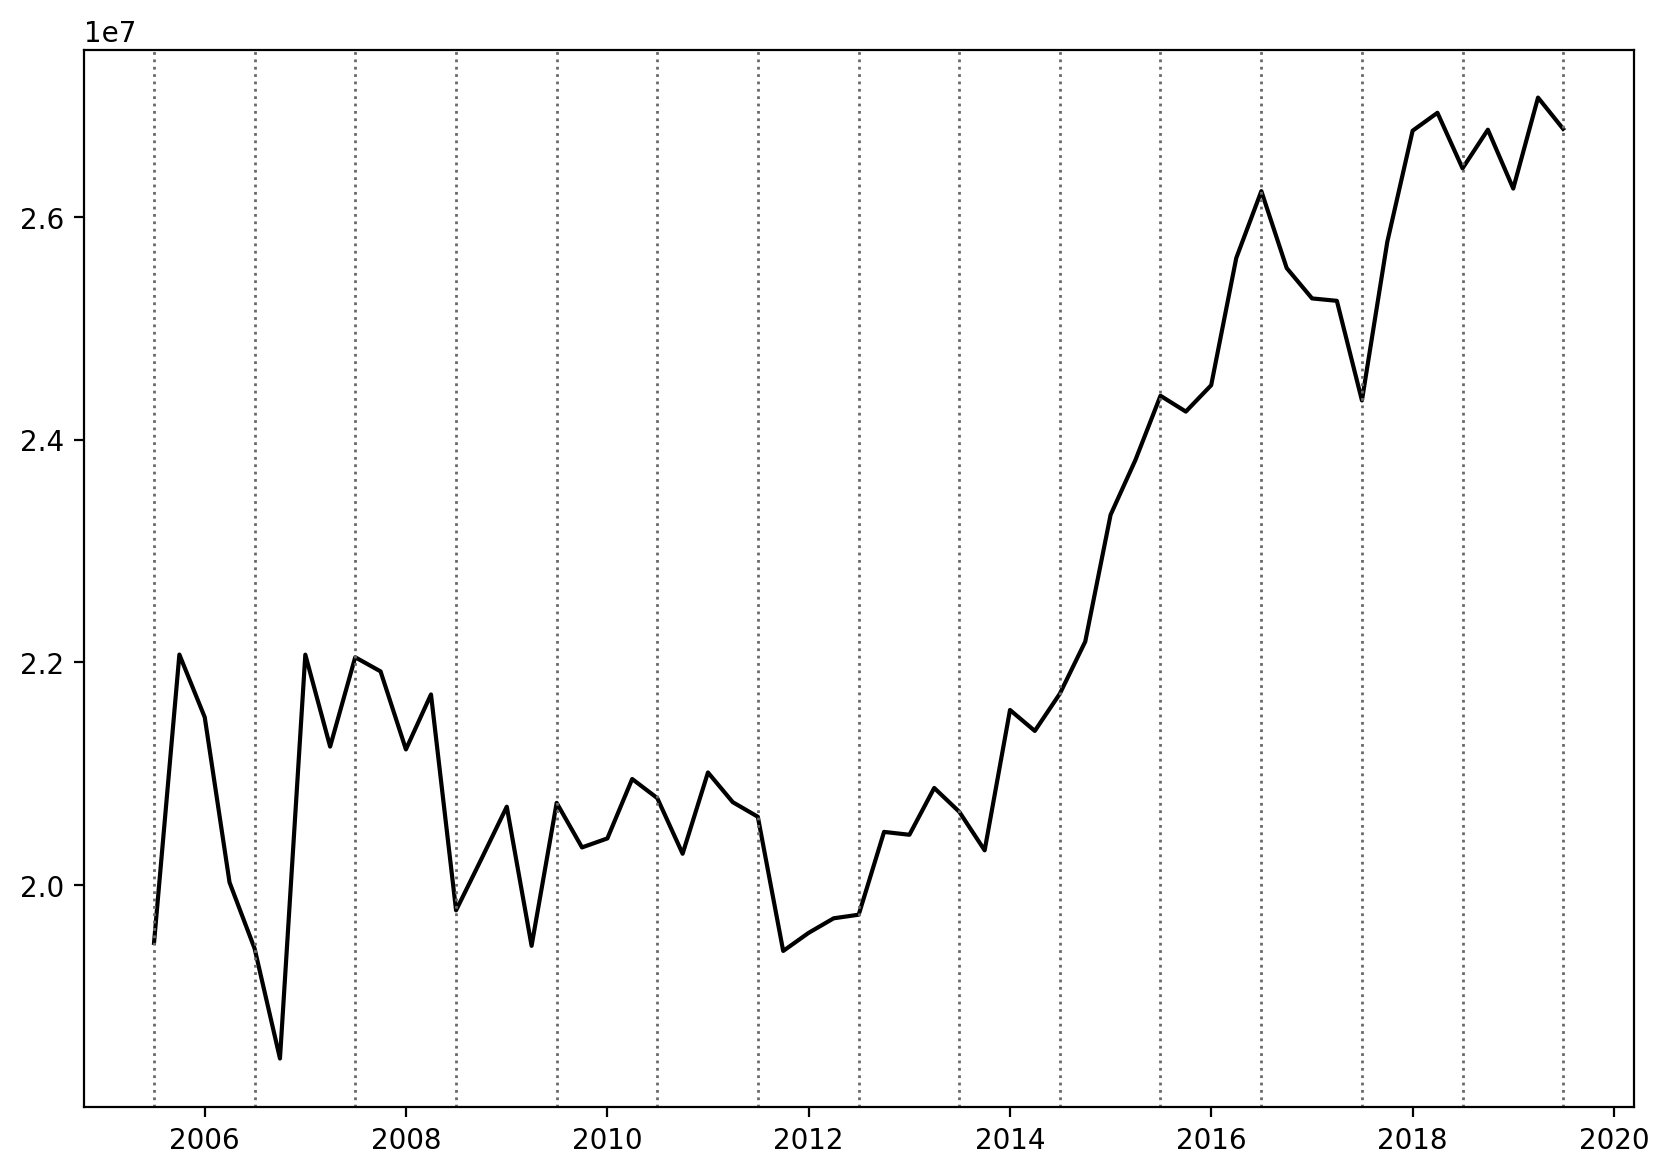

In [ ]:
plt.figure(figsize=(10, 7),dpi=200)

plt.plot(time_seriesdate.index,time_seriesdate['TradePrice'],color='black')

# draw a vertical dot line every four quarters on x axis
for ind in range(0,len(time_seriesdate),4):

    xLine=time_seriesdate.index[ind]
    plt.axvline(x=xLine, color='dimgray',ls=':', lw=1, label='vline_single - partial height')

plt.show

### Plot the Data Decomposition 

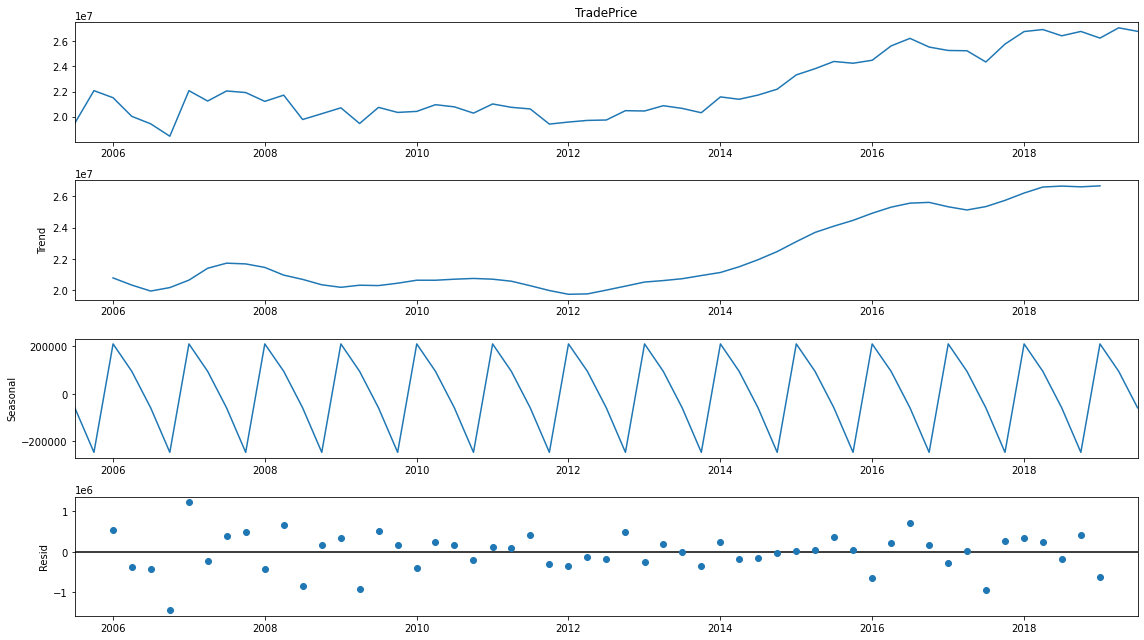

In [ ]:
decompose_data = seasonal_decompose(time_seriesdate.TradePrice)
fig = decompose_data .plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

### Stationary or non-stationary Data

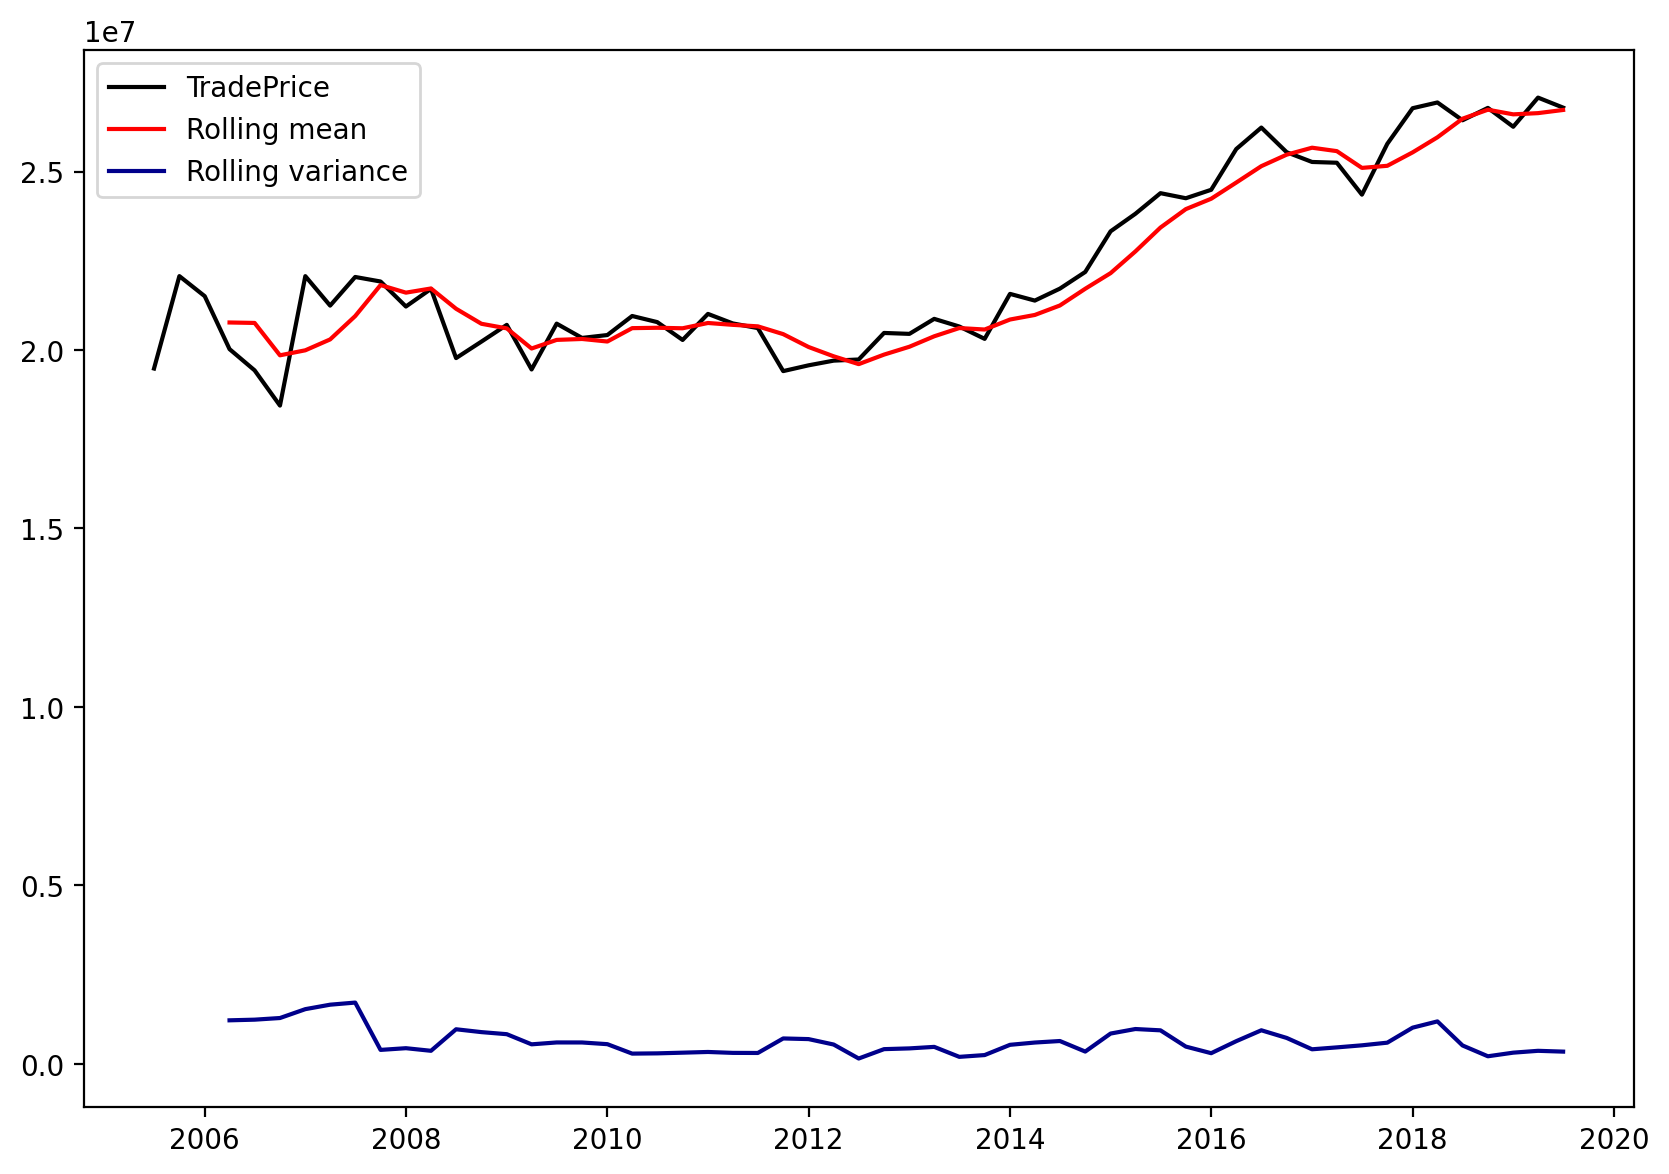

In [ ]:
# get the rolling mean for every 4 instances
rollingMean=time_seriesdate.TradePrice.rolling(window=4).mean()

# get the rolling Standard Diviation for every 4 instances
rollingSTD=time_seriesdate.TradePrice.rolling(window=4).std()
plt.figure(figsize=(10, 7),dpi=200)

# plot the TradePrice, Rolling Mean, and Rolling STD
TradePrice_Output=plt.plot(time_seriesdate.TradePrice,color='black',label='TradePrice')
mean=plt.plot(rollingMean,color='red',label='Rolling mean')
stddev=plt.plot(rollingSTD,color='darkblue',label='Rolling variance')
    
plt.legend()
plt.show()

In [ ]:
# take the differencing (First order, Second order, Third order), Then check the P-values for each Order
ad_result=adfuller(time_seriesdate.TradePrice)
print('P-value: ',ad_result[1])
ad_result=adfuller(time_seriesdate.TradePrice.diff().dropna())
print('P-value: ',ad_result[1])
ad_result=adfuller(time_seriesdate.TradePrice.diff().diff().dropna())
print('P-value: ',ad_result[1])
ad_result=adfuller(time_seriesdate.TradePrice.diff().diff().diff().dropna())
print('P-value: ',ad_result[1])

P-value:  0.9409735077588556
P-value:  1.2415616648090387e-17
P-value:  9.298656843294855e-08
P-value:  0.00031864481302127084


### Plot PACF & ACF 

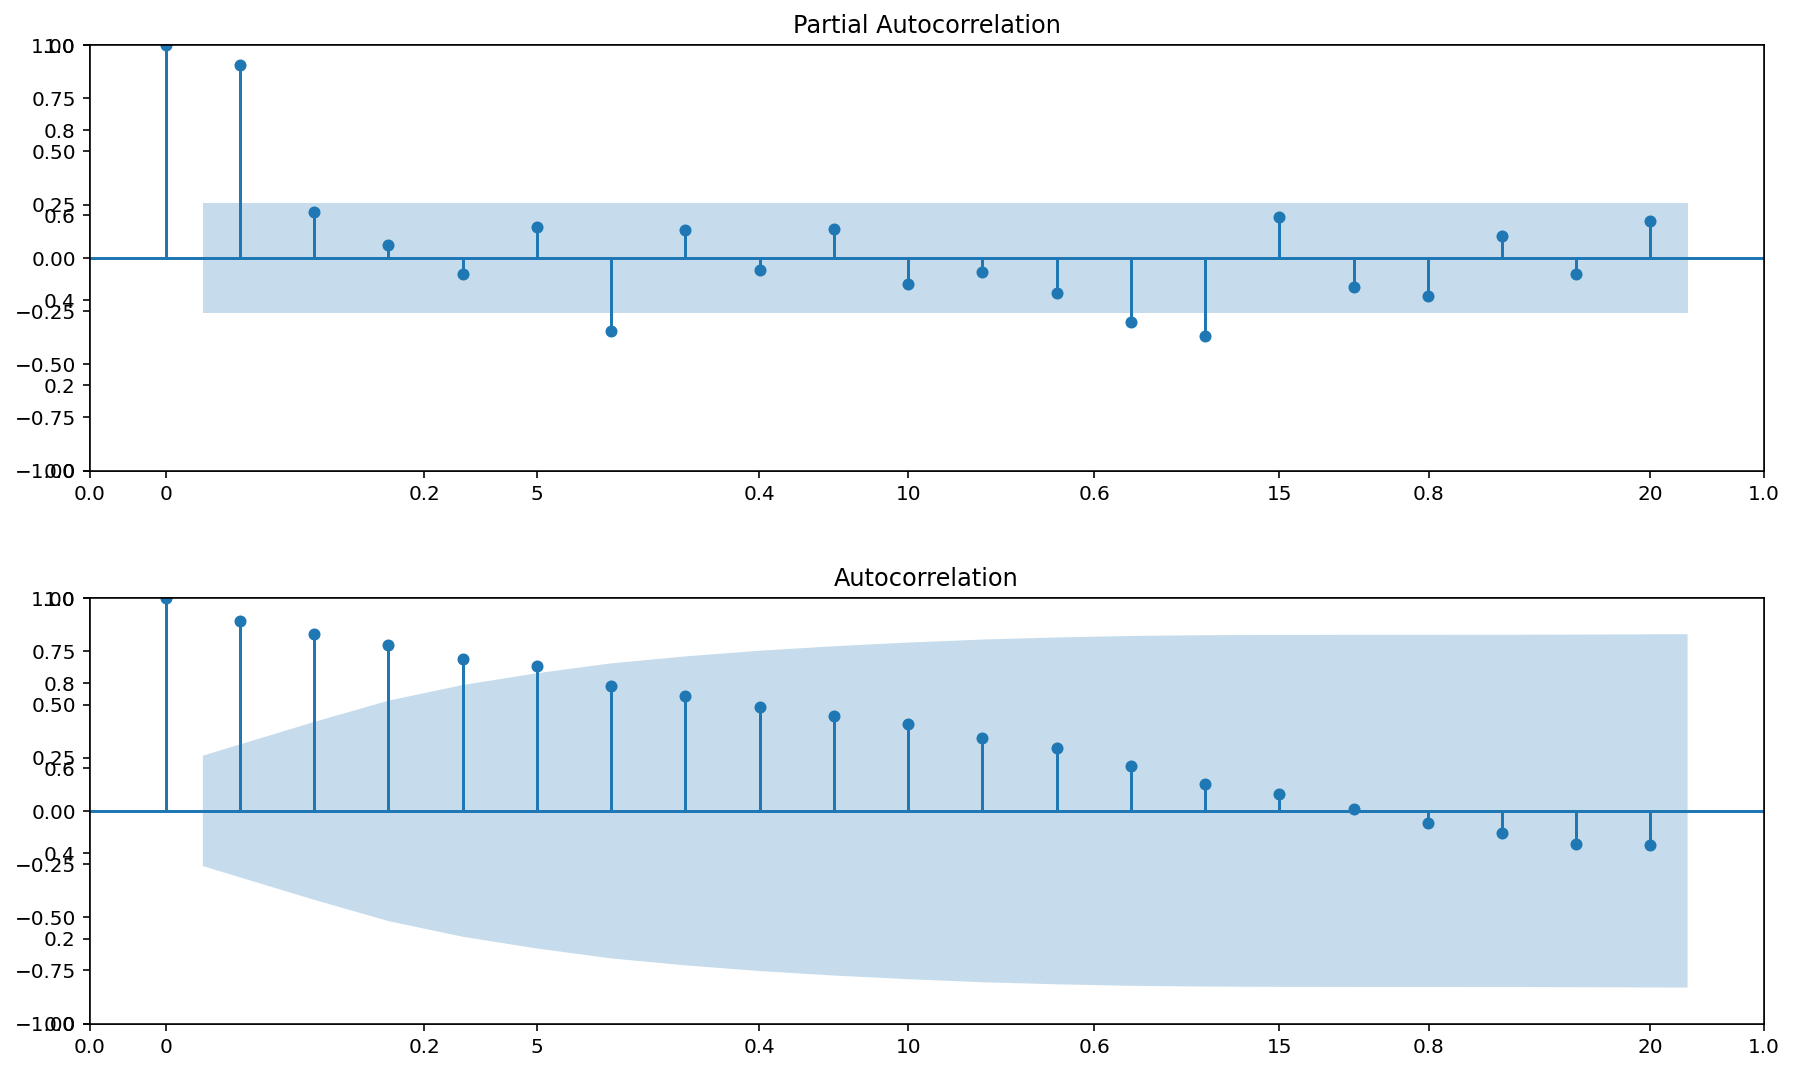

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(15,9),dpi=144)
plt.subplots_adjust(hspace=.3)

ax1 = fig.add_subplot(211)

# Plot the Partial Autocorrelation to find the order of MA
plot_pacf(time_seriesdate.TradePrice, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)

# Plot the Partial Autocorrelation to find the order of AR
plot_acf(time_seriesdate.TradePrice, lags=20,ax=ax2)
plt.show()

<a id='Destination_4.1.2'></a>


## Train Sample X

## Data Scaling 

The data is scaled "shrink" to fit whithin specific range to make it easier for the model to learn and better understand the data. <br>
The Type of data scaling used is <b>MinMax Scaler</b>

In [ ]:
def DataScaling(time_series):
    
    SC = MinMaxScaler()
    SC = SC.fit(time_series.iloc[:,1:8])
    SC_X=SC.transform(time_series.iloc[:,1:8])

    #save the scaled data in dataframe
    time_seriesD=pd.DataFrame(SC_X,columns=[time_series.iloc[:,1:8].columns],index=time_series.index)
    time_seriesD['Date']=time_series['Date']
    
    SC_y = MinMaxScaler()
    SC_y = SC_y.fit(time_series.iloc[:,0:1])
    SC_yy=SC_y.transform(time_series.iloc[:,0:1])
    
    #save the output "TradePrice" in dataframe
    time_seriesD['TradePrice']=SC_yy
    scalers = {'SC':SC,'SC_y':SC_y}
    
    
    return scalers, time_seriesD

## Sliding Windows validation

This type of data validation is applied on time dependent data during the training phase.

This function works in each iteration as following:

1. Create Window slice takes instances as input, based on time series shape 
2. take the next 3 instances to forecast 
3. move 1 step length
4. repeat the process until the last instance

In [ ]:
def SlideValidation(time_series):

    
    # select the Windows Size based on Time Series shape
    if time_series.shape[0]>=40:
        WLN=35
    elif time_series.shape[0]> 35 and time_series.shape[0]<40:
        WLN=30
    else:
        WLN=20

    windowLength = WLN
    
    #select the next 3 instances to forecast
    forecastHoraizon = ForecastingHorizon([1, 2, 3])
    
    #based on Window and forecast return the number of folds
    folds = SlidingWindowSplitter(window_length=windowLength, fh=forecastHoraizon)
    number_splits = folds.get_n_splits(time_series['TradePrice'])
    print(f"Number of Folds = {number_splits}")
    
    #in each iteration move forward one step
    trainWindow = []
    testWindow = []
    for i, (train, test) in enumerate(folds.split(time_series['TradePrice'])):
        trainWindow.append(train)
        testWindow.append(test)

    return trainWindow, testWindow





## ARIMAX Model 

### ARIMAX Model Function


ARIMAX Function is defined to train and predict Sliding Validation folds in each iteration. <br>
The function returns the three metric results <b> [RMSE, MAE, and MAPE]</b>

In [ ]:
def ARIMAXModel(trainFold,testFold,scalers):
    
    exogColumns=train_fold.columns.drop('TradePrice')

    model_autoARIMAX = auto_arima(train_fold.TradePrice, start_p=1, start_q=1,test='adf',                   
        max_p=5, max_q=5, max_d=5,m=4,d=1, D=0,start_P=0, start_Q=0, max_P=0, max_Q=0,max_D=0,
        stationary=False,random_state=20220915,seasonal=False,  trace=True,error_action='ignore',
        suppress_warnings=True, stepwise=True,exogenous= train_fold[exogColumns])


    model_fit = model_autoARIMAX.fit(train_fold.TradePrice,train_fold[exogColumns])
    
    exogColumnsTest=test_fold.columns.drop('TradePrice')
    predictions= model_autoARIMAX.predict(n_periods=test_fold.shape[0],exogenous=test_fold[exogColumnsTest])
    
    #for inverse result to calculate the MAPE inverse
    y_True=scalers['SC_y'].inverse_transform(test_fold[['TradePrice']].values)
    y_pred=scalers['SC_y'].inverse_transform(predictions.reshape(-1, 1))
    
    test_result = {'RMSE':mse(test_fold.TradePrice, predictions,squared=False), 'MAE':mae(test_fold.TradePrice, predictions), 
                   'MAPE':mape(test_fold.TradePrice, predictions),'MAPE_inverse':mape(y_True, y_pred)}


    
    return model_autoARIMAX,predictions, test_result


In [ ]:
# create empty dictionaries to save 
ARIMAXmodels = {}
Pred_DictARIMAX = {}
ARIMAXResult = {}
Train_foldDict={}
Test_foldDict={}
date_indexARIMAX={}
ind=1

# call the validation function to get the train and test folds
train_windows,test_windows= SlideValidation(time_series)

# call the scaling function to scale the data
scalers,time_seriesD=DataScaling(time_series)

# iterate and train the model based on the number of folds
for i,j in zip(train_windows,test_windows):
     
    #locate the train fold data from train_window                        
    train_fold=time_seriesD.iloc[i,:]
    #locate the test fold data from test_window                        
    test_fold=time_seriesD.iloc[j,:]
    
    #locat the dates of the test fold
    date_indexARIMAX[str(ind)]=time_seriesD.iloc[j,7:8]


    train_fold['Date']= train_fold['Date'].apply(pd.to_numeric, errors='coerce')
   # train_fold=train_fold.set_index('Date')
    test_fold['Date']= test_fold['Date'].apply(pd.to_numeric, errors='coerce')
    #test_fold=test_fold.set_index('Date')
    Train_foldDict[str(ind)]=train_fold
    Test_foldDict[str(ind)]=test_fold.TradePrice

    #train the model
    model_autoARIMAX,predictions, test_res=ARIMAXModel(train_fold,test_fold,scalers)

    # save the model fits and results
    ARIMAXmodels[str(ind)] = model_autoARIMAX
    Pred_DictARIMAX[str(ind)] = predictions
    ARIMAXResult[str(ind)] = test_res
    ind=ind+1
    

Number of Folds = 20
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-25.630, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-25.949, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-27.600, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-28.889, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=58.948, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-13.140, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-7.520, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-30.730, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-27.411, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-16.116, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-29.691, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-10.687, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.044 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : 

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-52.582, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-55.181, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-46.057, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.974 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-51.934, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-55.243, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-55.187, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-53.757, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=29.653, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.379 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-47.910, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-54.120, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-52.419, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-51.

In [ ]:
# print the average result of all test folds for sample X
ARIMAXResult_pd=pd.DataFrame(ARIMAXResult).T.round(4)
np.mean(ARIMAXResult_pd)

RMSE           0.107
MAE            0.096
MAPE           0.131
MAPE_inverse   0.033
dtype: float64

In [ ]:
#create Dataframe contain: Date, Test values, and Prediction.

# Empty list for instance index and dates in each folds
IndexFold = []
FoldFrame = []

#Loop through date dictionary and create dates Column
for Ind, FoldDates in date_indexARIMAX.items():
    IndexFold.append(Ind)
    FoldFrame.append(FoldDates)

    DatesColumn=pd.concat(FoldFrame, keys=IndexFold)

            
#Empty list for instance index and test set of "TradePrice" in each folds
IndexTest = []
FoldTestValue = []

#Loop through test dictionary and create actual"TradePrice"  Column
for ind, value in Test_foldDict.items():
    IndexTest.append(ind)
    FoldTestValue.append(value)
TradeTestColumn=pd.concat(FoldTestValue, keys=IndexTest)

# get the prediction values from dictionary
ARIMAXprediction=pd.DataFrame(Pred_DictARIMAX,columns=Pred_DictARIMAX.keys())

#Reshape the dataframe from horizental to vertical
ARIMAXprediction=ARIMAXprediction.melt(  var_name="indexvalues", value_name="Prediction")

#Create dataframe with ARIMAX result:
ARIMAX_Result = pd.concat([DatesColumn,TradeTestColumn],axis=1)
ARIMAX_Result.reset_index(drop=True,inplace=True)
ARIMAX_Result['predict']=ARIMAXprediction.Prediction

# Remove Duplicate Dates
ARIMAX_Result = ARIMAX_Result[~ARIMAX_Result["Date"].duplicated()]
ARIMAX_Result.head()

,Date,TradePrice,predict
0,2014-04-01,0.341,0.325
1,2014-07-01,0.380,0.332
2,2014-10-01,0.434,0.339
5,2015-01-01,0.566,0.340
8,2015-04-01,0.623,0.372


In [ ]:
#create temporary list to strip the date column and take only "year-month-day" information
tempList=[]
for dates in ARIMAX_Result['Date'].values:
    for date in dates:
        tempList.append(str(date)[:-19])

ARIMAX_Result['Date']=tempList


In [ ]:
# inverse the minMax scaler effect form actual and prediction values of "TradePrice"
y_TrueARIMAX=scalers['SC_y'].inverse_transform(ARIMAX_Result[['TradePrice']].values)
y_predARIMAX=scalers['SC_y'].inverse_transform(ARIMAX_Result[['predict']].values)

In [ ]:
def forecast_summary(y_true, y_pred,dates):
    
    
    print("results on forecast:")
    print("     RMSE = "+format(mse(y_true, y_pred, squared=False),".4f"))
    print("     MAE = "+format(mae(y_true, y_pred),".4f"))
    print("     MAPE = "+format(mape(y_true, y_pred),".4f"))
    
    fig, ax = plt.subplots(figsize=(16,6))
    ax.set_title('Real Price and Predicted Price Series')
    ax.set_ylabel('Trade Price',fontsize=14)
#     ax.set_xlabel('Year-Q',fontsize=14)
    ax.bar(dates,y_true,color='k', width= 0.8, label = 'Original values')
    ax.bar(dates, y_pred, color='gray', width = 0.4, label = 'Predicted values')
#     ax.yaxis.set_major_locator(MultipleLocator(1e7))
    plt.xticks(rotation=45)
#     plt.xlim(0,dates[-1])
   # ax.yaxis.set_major_locator(MultipleLocator(2e6))
    ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.f'))
    plt.grid(axis='y')
    plt.legend(prop={'size': 16}) 
    plt.show()
    
    # R2 plot
    r2 = r2_score(y_true,y_pred)

    fig, ax = plt.subplots(figsize=(20,8))

    plt.scatter(y_true,y_pred,marker='s',color = 'gray',label = 'R2 = '+format(r2,'.4f'))
    plt.plot(y_true, y_true, color = 'k', label = 'True TradePrice')
    ax.set_title('Scatter plot of true vs. predicted values, test_size='+str(len(y_pred)),fontsize=16)
    ax.set_ylabel('Predicted TradePrice',fontsize=14)
    ax.set_xlabel('True TradePrice',fontsize=14)
    plt.grid()
    plt.legend(prop={'size': 16})
    plt.show()



results on forecast:
     RMSE = 1218903.6343
     MAE = 986579.3413
     MAPE = 0.0395


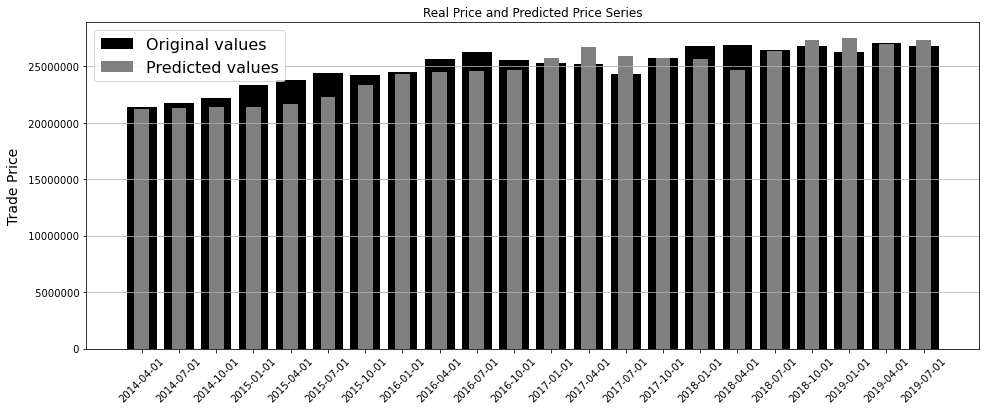

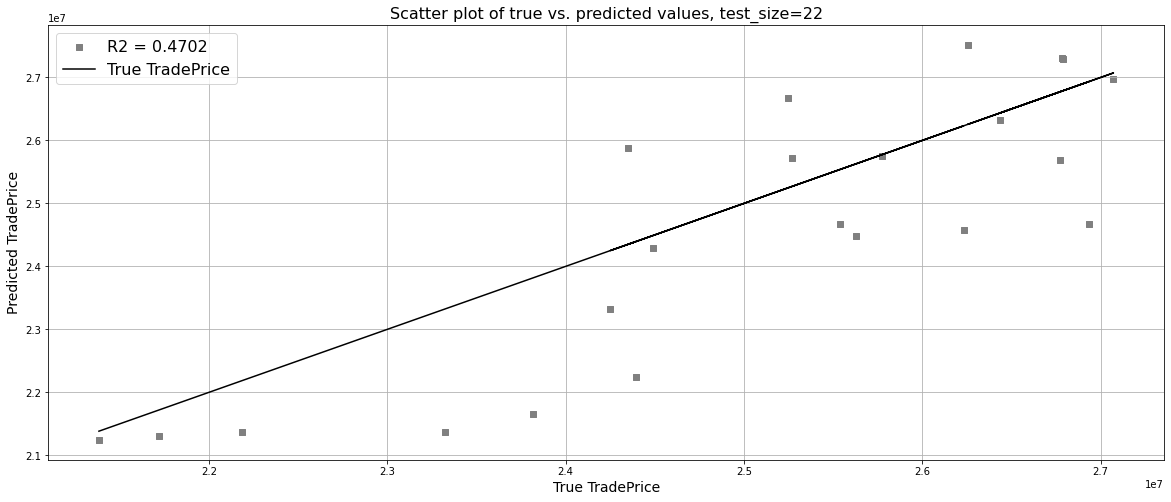

In [ ]:
forecast_summary(y_TrueARIMAX.flatten(),y_predARIMAX.flatten(),ARIMAX_Result['Date'].values.flatten())


## SARIMAX Model

### SARIMAX Model Function

SARIMAX Function is defined to train and predict Sliding Validation folds in each iteration. <br>
The function returns the three metric results <b> [RMSE, MAE, and MAPE]</b>

In [ ]:
def SARIMAXModel(trainFold,testFold,scalers):
    
    # locate the all the indicate features, Except TradePrice
    exogColumns=train_fold.columns.drop('TradePrice')
    exogColumnsTest=test_fold.columns.drop('TradePrice')

    # Define the SARIMAX parameters
    model_autoSARIMAX = auto_arima(train_fold.TradePrice, start_p=1, start_q=1,test='adf',                   
              max_p=5, max_q=5, max_d=5,m=4,d=1, D=1,start_P=1, start_Q=1, max_P=5, max_Q=5,max_D=5 ,stationary=False,random_state=20220915,
              seasonal=True,  trace=True,error_action='ignore', suppress_warnings=True, stepwise=True,
              exogenous= train_fold[exogColumns])

    # Fit the model
    model_fit = model_autoSARIMAX.fit(train_fold.TradePrice,train_fold[exogColumns])
    
    #predict the next instnaces
    predictions= model_autoSARIMAX.predict(n_periods=test_fold.shape[0],exogenous=test_fold[exogColumnsTest])

    # Inverse the MinMax scaler for the test fold data
    y_True=scalers['SC_y'].inverse_transform(test_fold[['TradePrice']].values)
    
    # Inverse the MinMax scaler for the prediction data
    y_pred=scalers['SC_y'].inverse_transform(predictions.reshape(-1, 1))
    print(y_pred)
    
    # Create Dictionary to save all the metrics
    test_result = {'RMSE':mse(test_fold.TradePrice, predictions,squared=False), 'MAE':mae(test_fold.TradePrice, predictions), 
                   'MAPE':mape(test_fold.TradePrice, predictions),'MAPE_inverse':mape(y_True, y_pred)}
    
    return model_autoSARIMAX,predictions, test_result

In [ ]:
# create empty dictionaries to save 
SARIMAXmodels = {}
Pred_DictSARIMAX = {}
SARIMAXResult = {}
Train_foldDict={}
Test_foldDict={}
date_indexSARIMAX={}
ind=1

# call the validation function to get the train and test folds
train_windows,test_windows= SlideValidation(time_series)

# call the scaling function to scale the data
scalers,time_seriesD=DataScaling(time_series)

# iterate and train the model based on the number of folds
for i,j in zip(train_windows,test_windows):
    
    #locate the train fold data from train_window                        
    train_fold=time_seriesD.iloc[i,:]
    
    #locate the test fold data from test_window                        
    test_fold=time_seriesD.iloc[j,:]
    
     #locat the dates of the test fold
    date_indexSARIMAX[str(ind)]=time_seriesD.iloc[j,7:8]
 
    

    train_fold['Date']= train_fold['Date'].apply(pd.to_numeric, errors='coerce')
   # train_fold=train_fold.set_index('Date')
    test_fold['Date']= test_fold['Date'].apply(pd.to_numeric, errors='coerce')
    #test_fold=test_fold.set_index('Date')
    Train_foldDict[str(ind)]=train_fold
    Test_foldDict[str(ind)]=test_fold.TradePrice

    # train the model 
    model_autoSARIMAX,predictions, test_res=SARIMAXModel(train_fold,test_fold,scalers)

    # save the model fits and results
    SARIMAXmodels[str(ind)] = model_autoSARIMAX
    Pred_DictSARIMAX[str(ind)] = predictions
    SARIMAXResult[str(ind)] = test_res
    ind=ind+1
    

Number of Folds = 20
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-31.234, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=48.598, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-31.921, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-34.288, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=-28.246, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=-33.335, Time=0.11 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=-24.246, Time=0.12 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=-33.671, Time=0.09 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=-29.715, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=-34.228, Time=0.09 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=-32.620, Time=0.11 sec
 ARIMA(0,1,2)(0,1,1)[4]             : AIC=-27.226, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-33.574, Time=0.09 sec
 ARIMA(1,1,2)(0,1,1)[4]             : AIC=-29.070, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[4] int

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-39.215, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=39.270, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-46.003, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-43.549, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-40.759, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[4]             : AIC=-44.795, Time=0.12 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=-42.877, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-44.674, Time=0.09 sec
 ARIMA(1,1,0)(2,1,1)[4]             : AIC=-40.107, Time=0.14 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=-46.559, Time=0.08 sec
 ARIMA(0,1,0)(2,1,0)[4]             : AIC=-43.190, Time=0.10 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=-26.269, Time=0.10 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=-26.958, Time=0.09 sec
 ARIMA(0,1,0)(2,1,1)[4]             : AIC=-17.487, Time=0.12 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=-44.55

 ARIMA(0,1,1)(0,1,0)[4]             : AIC=-45.634, Time=0.07 sec
 ARIMA(2,1,1)(0,1,0)[4]             : AIC=-41.835, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[4] intercept   : AIC=-47.778, Time=0.22 sec

Best model:  ARIMA(1,1,0)(0,1,0)[4]          
Total fit time: 1.195 seconds
[[25755394.97326744]
 [25220651.00395894]
 [25035229.80075948]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-38.372, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=24.786, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-46.054, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-40.348, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-46.837, Time=0.07 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-45.421, Time=0.09 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=-43.394, Time=0.11 sec
 ARIMA(2,1,0)(0,1,0)[4]             : AIC=-40.973, Time=0.08 sec
 ARIMA(1,1,1)(0,1,0)[4]             : AIC=-41.481, Time=0.08 sec
 ARIMA(0,1,1)(0,1,0)[4]             :

[[26986310.48281505]
 [27377155.04373158]
 [26808471.99305491]]


In [ ]:
# print the average result of all test folds for sample X
SARIMAXResult_pd=pd.DataFrame(SARIMAXResult).T.round(4)
np.mean(SARIMAXResult_pd)

RMSE           0.129
MAE            0.115
MAPE           0.157
MAPE_inverse   0.039
dtype: float64

In [ ]:
#create Dataframe contain: Date, Test values, and Prediction.

# Empty list for instance index and dates in each folds
IndexFold = []
FoldFrame = []

#Loop through date dictionary and create dates Column
for Ind, FoldDates in date_indexSARIMAX.items():
    IndexFold.append(Ind)
    FoldFrame.append(FoldDates)

    DatesColumn=pd.concat(FoldFrame, keys=IndexFold)

            
#Empty list for instance index and test set of "TradePrice" in each folds
IndexTest = []
FoldTestValue = []

#Loop through test dictionary and create actual"TradePrice"  Column
for ind, value in Test_foldDict.items():
    IndexTest.append(ind)
    FoldTestValue.append(value)
TradeTestColumn=pd.concat(FoldTestValue, keys=IndexTest)

# get the prediction values from dictionary
SARIMAXprediction=pd.DataFrame(Pred_DictSARIMAX,columns=Pred_DictSARIMAX.keys())

#Reshape the dataframe from horizental to vertical
SARIMAXprediction=SARIMAXprediction.melt(  var_name="indexvalues", value_name="Prediction")

#Create dataframe with ARIMAX result:
SARIMAX_Result = pd.concat([DatesColumn,TradeTestColumn],axis=1)
SARIMAX_Result.reset_index(drop=True,inplace=True)
SARIMAX_Result['predict']=SARIMAXprediction.Prediction

# Remove Duplicate Dates
SARIMAX_Result = SARIMAX_Result[~SARIMAX_Result["Date"].duplicated()]
SARIMAX_Result.head()

,Date,TradePrice,predict
0,2014-04-01,0.341,0.508
1,2014-07-01,0.380,0.414
2,2014-10-01,0.434,0.562
5,2015-01-01,0.566,0.577
8,2015-04-01,0.623,0.450


In [ ]:
#create temporary list to strip the date column and take only "year-month-day" information
tempList=[]
for dates in SARIMAX_Result['Date'].values:
    for date in dates:
        tempList.append(str(date)[:-19])

SARIMAX_Result['Date']=tempList

In [ ]:
# inverse the minMax scaler effect form actual and prediction values of "TradePrice"
y_TrueSARIMAX=scalers['SC_y'].inverse_transform(SARIMAX_Result[['TradePrice']].values)
y_predSARIMAX=scalers['SC_y'].inverse_transform(SARIMAX_Result[['predict']].values)

In [ ]:
def forecast_summary(y_true, y_pred,dates):
    
    
    print("results on forecast:")
    print("     RMSE = "+format(mse(y_true, y_pred, squared=False),".4f"))
    print("     MAE = "+format(mae(y_true, y_pred),".4f"))
    print("     MAPE = "+format(mape(y_true, y_pred),".4f"))
    
    fig, ax = plt.subplots(figsize=(16,6))
    ax.set_title('Real Price and Predicted Price Series')
    ax.set_ylabel('Trade Price',fontsize=14)
#     ax.set_xlabel('Year-Q',fontsize=14)
    ax.bar(dates,y_true,color='k', width= 0.8, label = 'Original values')
    ax.bar(dates, y_pred, color='gray', width = 0.4, label = 'Predicted values')
#     ax.yaxis.set_major_locator(MultipleLocator(1e7))
    plt.xticks(rotation=45)
#     plt.xlim(0,dates[-1])
   # ax.yaxis.set_major_locator(MultipleLocator(2e6))
    ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.f'))
    plt.grid(axis='y')
    plt.legend(prop={'size': 16}) 
    plt.show()
    
    # R2 plot
    r2 = r2_score(y_true,y_pred)

    fig, ax = plt.subplots(figsize=(20,8))

    plt.scatter(y_true,y_pred,marker='s',color = 'gray',label = 'R2 = '+format(r2,'.4f'))
    plt.plot(y_true, y_true, color = 'k', label = 'True TradePrice')
    ax.set_title('Scatter plot of true vs. predicted values, test_size='+str(len(y_pred)),fontsize=16)
    ax.set_ylabel('Predicted TradePrice',fontsize=14)
    ax.set_xlabel('True TradePrice',fontsize=14)
    plt.grid()
    plt.legend(prop={'size': 16})
    plt.show()


results on forecast:
     RMSE = 1581604.1831
     MAE = 1194192.4288
     MAPE = 0.0478


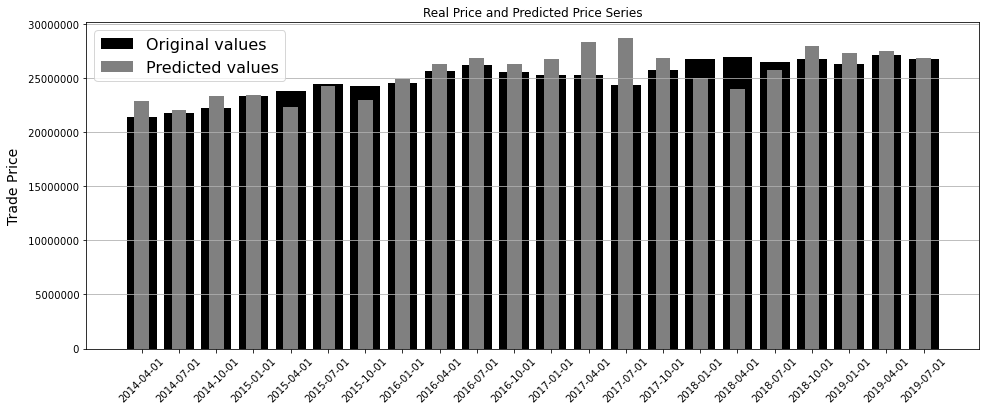

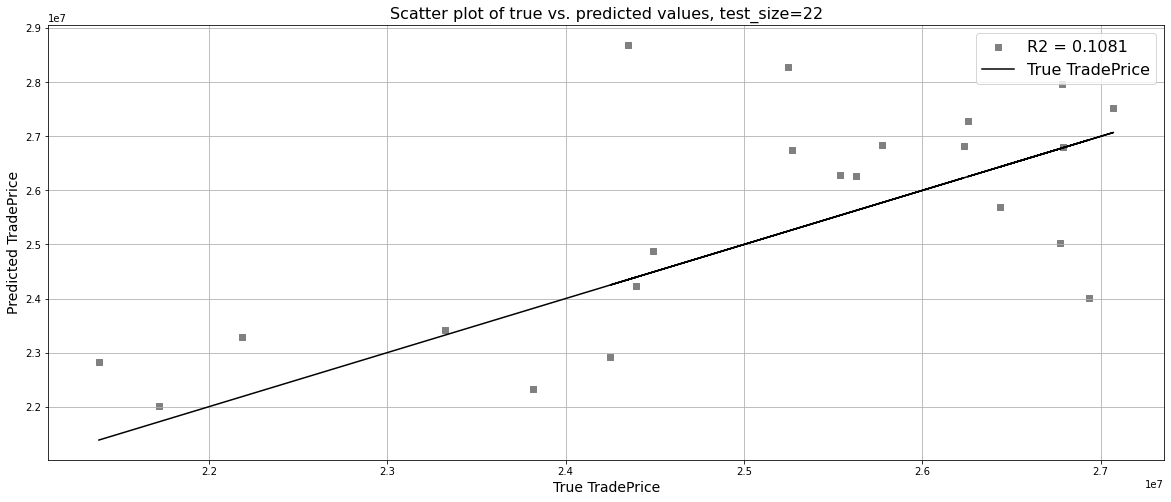

In [ ]:
forecast_summary(y_TrueSARIMAX.flatten(),y_predSARIMAX.flatten(),SARIMAX_Result['Date'].values.flatten())

                      _______________________________________________

<a id='Destination_4.1.3'></a>


## Train for All Possible X

### Fit and Predict ARIMAX

In [ ]:
# create Empty Dictionaries to save data and results
timeSeriesDict_Aramix = {}#time_series_dict = {}
TrainFoldDict_Aramix={}#Train_foldDict={}
TestFoldDict_Aramix={}#Test_foldDict={}
#time_seq_data_dict = {}
ScalersDict_Aramix={}#scalers_dict = {}
#fold_indecies_dict = {}
ARIMAX_model_dict = {}
historiesDict_Arimax = {}
testResultDict_Arimax = {}
date_index={}


# create empty dataframe to save the test result and the model category X
testResultRIMAXdf = pd.DataFrame(columns = ['RMSE','MAE','MAPE'])
ARIMAXmodels_df = pd.DataFrame(columns = ['Type-CityPlanning'])

# locate "Type" in df
for Type in df['Type'].unique():
    temp_df = df.loc[df['Type'] == Type]
    
    #locate "CityPlanning" in df
    for CityPlanning in df['CityPlanning'].unique():
        
        temp_df_2 = temp_df.loc[df['CityPlanning'] == CityPlanning]
        
        # take random sample X
        if temp_df_2.empty!=True:
            rand_sample = temp_df_2.sample()
            x = pd.Series(rand_sample.values.flatten(),index = rand_sample.columns)
        else:
            continue
        
        # Create Time series with mean point scheme
        time_series = create_timeseries(df,x)
        if type(time_series) == pd.core.frame.DataFrame: 
            timeSeriesDict_Aramix[Type+'-'+CityPlanning]= time_series

            # add "Date" column and convert to datetime type
            time_series['Date']=pd.to_datetime(time_series['Date'])
            #Convert all columns to numerical types
            time_series=time_series.apply(pd.to_numeric)
            time_series['Date']=pd.to_datetime(time_series['Date'])

            #call the validation and data scaling functions
            train_windows,test_windows=SlideValidation(time_series)
            scalers,time_seriesD=DataScaling(time_series)

            # the nested loop to train and predicts all folds of sample X
            for i,j in zip(train_windows,test_windows):
                
                #locate the train and test folds data from train_window & test_window                                
                train_fold=time_seriesD.iloc[i,:]
                test_fold=time_seriesD.iloc[j,:]
                
                #locate the dates of test folds                              
                date_index[Type+'-'+CityPlanning]=time_seriesD.iloc[j,7:8]
                
                # save the data in dictionaries
                TrainFoldDict_Aramix[Type+'-'+CityPlanning]=train_fold
                TestFoldDict_Aramix[Type+'-'+CityPlanning]=test_fold.TradePrice
                ScalersDict_Aramix[Type+'-'+CityPlanning] = scalers

                train_fold['Date']= train_fold['Date'].apply(pd.to_numeric, errors='coerce')
                test_fold['Date']= test_fold['Date'].apply(pd.to_numeric, errors='coerce')
                
                # fit the train fold and return the prediction and results
                model_autoARIMAX,predictions, test_results=ARIMAXModel(train_fold,test_fold,scalers)

                # save the models fit, prediction and tesult
                ARIMAX_model_dict[Type+'-'+CityPlanning] = model_autoARIMAX
                historiesDict_Arimax[Type+'-'+CityPlanning] = predictions
                testResultDict_Arimax[Type+'-'+CityPlanning] = test_results
            
            test_res_df = pd.DataFrame(test_results,index=range(1,len(test_results))).T.round(4)
            testResultRIMAXdf = pd.concat([testResultRIMAXdf,test_res_df],axis=0)
            ARIMAXmodels_df =  pd.concat([ARIMAXmodels_df,pd.Series(Type+'-'+CityPlanning)],axis=0)



Number of Folds = 20
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-23.313, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-20.005, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-21.725, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-24.725, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=64.891, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-18.625, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-17.448, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-26.683, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-25.260, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-22.860, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-23.715, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-20.591, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.947 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   :

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-39.195, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-41.820, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=48.013, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-35.481, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-31.446, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-43.829, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-41.171, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-41.153, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-41.196, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-39.004, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.917 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-36.138, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-35.949, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-38.777, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   

 ARIMA(4,1,1)(0,0,0)[0]             : AIC=-46.005, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-37.042, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=-43.215, Time=0.11 sec

Best model:  ARIMA(4,1,0)(0,0,0)[0]          
Total fit time: 1.692 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-22.430, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-36.674, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-42.341, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-37.814, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=48.223, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-44.461, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-44.489, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-45.359, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-45.612, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-42.107, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1.143, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.923 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=43.350, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.303, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=0.617, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.206, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=84.593, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.370 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.080, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.638, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.536, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.229, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=84.259, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-0.088, Time=0.09

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8.381, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=76.761, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6.819, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4.796, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-10.460, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-11.640, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-9.730, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-3.790, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-6.950, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-8.918, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-8.143, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-6.167, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.183 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7.985, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7.5

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9.451, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.680, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.502, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.929, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=87.576, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.369 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=60.689, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2.552, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.700, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.475, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=87.448, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.375 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8.838, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1.780, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=0.779, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1.095, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=26.533, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.930 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.009, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2.137, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3.224, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5.846, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=82.760, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4.819, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2.922, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-9.195, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6.489, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-6.991, T

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13.470, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10.586, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14.402, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14.846, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=74.310, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-13.871, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-11.007, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-17.699, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-15.759, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-15.910, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-16.408, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-13.007, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.946 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-14.890, Time=0.

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-20.294, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14.329, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=67.797, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-9.696, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-8.232, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-22.649, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-11.509, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-12.735, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-16.300, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-10.271, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.937 seconds
Number of Folds = 19
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=24.321, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=35.598, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25.888, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=21.560, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=23.524, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=19.384, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=19.563, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=19.575, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=19.646, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=21.506, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.936 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22.745, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36.561, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23.139, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21.729, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=121.457, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=24.502, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=24.86

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=21.306, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=22.357, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=16.223, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=19.523, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=19.260, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=20.682, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=20.391, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.929 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=20.383, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=35.220, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22.688, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17.118, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=120.117, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=21.005, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=20.98

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21.436, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=116.124, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=20.166, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=48.273, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=36.250, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=34.703, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=18.307, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=19.225, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=46.210, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=20.164, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=19.973, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=20.142, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.225 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26.079, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=29.42

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=13.991, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=15.085, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=13.353, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=17.121, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.228 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16.915, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26.160, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22.804, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14.195, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=111.057, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=47.388, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=24.710, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=12.244, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=13.280, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=12.53

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3.922, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2.905, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.002 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.690, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.105, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5.135, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4.077, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=85.002, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=0.234, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16.773, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-7.148, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-2.785, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3.560, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-8.336, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2.922, 

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-14.298, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.929 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-12.506, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4.886, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14.114, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13.166, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=80.010, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-14.265, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-11.225, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-11.397, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-9.034, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-16.217, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-16.106, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-13.554, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2.471, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1.568, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8.003, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3.385, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=83.328, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1.447, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=102.882, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-9.999, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-3.536, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3.863, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5.396, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=99.921, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.935 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5.785, Time=0.09 sec
 ARIM

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-26.070, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-28.742, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-31.253, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-23.672, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.928 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-18.416, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22.649, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-31.395, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4.679, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62.248, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-29.950, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16.167, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-33.351, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-32.034, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : 

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-42.770, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-43.956, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-41.439, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.923 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-42.446, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-33.222, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-42.530, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-43.966, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=51.675, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-40.442, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-38.151, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-46.123, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-44.433, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-42.611, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=18.198, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=13.865, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=14.761, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=13.961, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=14.770, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=15.984, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.933 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16.281, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=31.428, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15.250, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14.972, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=116.324, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=17.242, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=18.923, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=13.31

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9.285, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=13.309, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13.641, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=15.420, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=7.322, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=7.797, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=10.888, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=10.537, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=10.195, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=12.513, Time=0.09 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.233 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5.136, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.464, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.272, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2.451, Time

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=17.614, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-3.056, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-0.706, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-0.810, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1.012, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=14.212, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.926 seconds
Number of Folds = 5
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=44.973, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=51.445, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=45.812, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=42.523, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=119.333, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=107.898, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=91.176, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]    

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=24.784, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=38.350, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=30.387, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22.455, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=123.246, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=42.852, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=28.080, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=19.859, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=22.419, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=20.561, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=28.342, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=22.840, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.925 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=21.067, Time=0.09 sec
 ARI

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-3.310, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-3.598, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5.100, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6.931, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-3.149, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-1.629, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3.286, Time=0.09 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.442 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.804, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4.642, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.974, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.295, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=89.538, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=0.383, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=0.297, Time=

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26.067, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21.529, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23.164, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22.858, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=57.517, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.331 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=27.143, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23.007, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25.085, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24.795, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=59.039, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.334 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=25.528, Time=0.08 sec
 ARIMA(0,1,0)

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-28.864, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-27.122, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-28.627, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.218 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-22.799, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3.321, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-22.714, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=79.204, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=81.576, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15.848, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=53.742, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-14.396, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-22.805, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-22.580, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AI

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-25.376, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-24.994, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-24.741, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-23.046, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-24.522, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.085 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-22.503, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2.723, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-20.450, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-23.143, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=82.173, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-20.040, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-21.801, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-25.405, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             :

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=105.870, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=14.389, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12.237, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5.264, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=52.063, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5.872, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=15.465, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=7.528, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.929 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=51.333, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18.776, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16.045, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12.618, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=103.759, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=35.802,

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=75.063, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=12.443, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=14.170, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=12.648, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=11.352, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=12.722, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=14.541, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.000 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.428, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18.521, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.835, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11.346, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=103.548, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=62.342, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14.140,

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10.648, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=99.941, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=17.823, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2.753, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5.295, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1.893, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=37.089, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.269, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4.257, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=0.841, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=0.602, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=0.730, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.207 seconds
Number of Folds = 11
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23.290, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22.973, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=34.574, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=27.042, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21.130, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=119.471, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=25.485, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=29.653, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=17.825, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=20.416, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=19.005, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=25.042, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=21.087, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.941 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23.967, Time=0.09 sec
 ARI

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=9.085, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11.042, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3.887, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5.790, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6.925, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5.378, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=9.038, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.922 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=25.379, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.065, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.718, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.123, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=95.962, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7.368, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=69.053, Time=0.

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=24.641, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=0.479, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3.251, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3.252, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5.013, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=22.443, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.942 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15.702, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25.872, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19.841, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14.541, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=110.768, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=34.350, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=40.313, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=11.564, T

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=10.350, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=17.512, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=12.339, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.924 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14.676, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25.676, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19.188, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12.729, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=110.575, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=40.840, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=45.614, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=10.444, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=12.381, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=13.692, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=17.20

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=49.947, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=8.069, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=9.734, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=11.252, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=36.265, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7.561, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=14.794, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=80.750, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=13.362, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=48.892, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.458 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23.221, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17.209, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16.022, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19.152, T

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=35.957, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.226 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=24.292, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20.331, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17.077, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16.336, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=105.227, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=14.919, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12.856, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=65.509, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=46.762, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=42.348, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=33.784, Time=0.24 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=47.921, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=11.27

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=21.695, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=15.385, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=17.142, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=16.800, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=19.872, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=19.089, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.926 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=24.842, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25.733, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22.602, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19.777, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=110.629, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=22.563, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=32.898, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=17.34

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=25.557, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=23.845, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=29.046, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=45.847, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.049 seconds
Number of Folds = 12
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=28.634, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=29.522, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=27.424, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26.636, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=65.502, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=107.162, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=105.218, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=24.432, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=26.430, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]  

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=36.141, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=107.729, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=77.227, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=31.773, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=33.769, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=34.131, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=36.836, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=34.011, Time=0.07 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 0.753 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=39.643, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=40.627, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=36.097, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=93.563, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=77.100, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=31.40

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=29.451, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22.133, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=121.931, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=16.584, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=18.669, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=21.108, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=22.700, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=14.656, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=12.838, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=64.780, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=27.447, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=16.746, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.124 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=70.868, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36.83

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=41.893, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39.704, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=32.809, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=44.798, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=124.601, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=24.696, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=24.087, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=24.553, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=25.324, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=23.232, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=43.876, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=53.905, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=81.510, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=21.296, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=24.516, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : A

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7.265, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-0.058, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8.822, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8.761, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=84.972, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6.979, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9.720, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-9.822, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-7.850, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-7.878, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-9.175, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6.059, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.919 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7.547, Time=0.09 sec
 ARIMA(

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10.812, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23.217, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.264, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16.367, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=108.114, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9.833, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=11.833, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11.801, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=14.378, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=7.985, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=8.257, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=9.838, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=9.921, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=8.453, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=11.941, Time=0.09 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]         

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8.549, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15.081, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.632, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.305, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=99.977, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7.685, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10.470, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3.649, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=5.627, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5.837, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3.832, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=7.898, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.928 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8.230, Time=0.09 sec
 ARIMA(0,1,0)(0

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=100.133, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=61.934, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=52.728, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6.152, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=55.627, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=27.428, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=11.468, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=22.510, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.939 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.130, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.140, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.244, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1.204, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=96.036, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5.602,

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-7.673, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-11.933, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2.272, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-9.845, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-9.726, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-11.581, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2.888, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-11.652, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-10.644, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-9.470, Time=0.10 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 1.831 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-0.802, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4.774, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.987, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-0.50

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4.620, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2.408, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2.790, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.925 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.776, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.688, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1.380, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5.451, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=94.584, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4.507, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3.246, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-8.621, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6.136, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-7.451, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-0.547, 

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-4.549, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.998 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10.311, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2.159, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11.085, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11.438, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=82.737, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=16.039, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13.540, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-13.876, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-12.612, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-11.912, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-13.059, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=7.083, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]      

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-24.313, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-18.040, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-10.933, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.119 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-21.751, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8.094, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-15.835, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-23.771, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=76.802, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-21.328, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4.876, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-26.036, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-23.829, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-23.347, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : 

 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3.345, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=101.680, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.472 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7.736, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36.118, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.231, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=50.097, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=121.014, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=47.325, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14.811, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=12.892, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7.685, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=8.755, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11.398, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=6.071, Ti

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6.037, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16.633, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.173, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4.502, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=101.529, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.169, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=40.513, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1.217, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3.798, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3.961, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2.696, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=35.900, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.926 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3.155, Time=0.09 sec
 ARIMA(0,1,0)

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-7.861, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=3.902, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-9.025, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.232 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6.607, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=0.683, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3.840, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7.988, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=85.579, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-8.147, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6.949, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=7.340, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=10.777, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-11.701, Tim

 ARIMA(2,1,0)(0,0,0)[0]             : AIC=18.057, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=20.437, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=19.478, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=19.935, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=18.983, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=21.936, Time=0.09 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.232 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16.796, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27.228, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20.836, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14.428, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=112.124, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=24.833, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=81.765, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=12.10

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=28.898, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=33.133, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25.163, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19.048, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=118.029, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=51.065, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=87.642, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=12.534, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=14.761, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=14.607, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=23.164, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=16.519, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.924 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=21.704, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=15.751, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=18.096, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=17.598, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=17.251, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=19.593, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.939 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=18.452, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25.381, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18.792, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16.060, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=110.278, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=17.813, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=34.196, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=13.94

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=36.814, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=23.960, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=42.982, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.990 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19.769, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=30.389, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25.724, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18.021, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=115.285, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=44.969, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=51.688, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=15.548, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=16.290, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=38.899, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=23.72

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=92.353, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7.630, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=32.442, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=35.759, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=77.266, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.373 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-48.930, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-47.916, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-48.344, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-50.749, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=36.980, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-54.140, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-51.416, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-40.634, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-62.760, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-65.105, Time=0.09 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=-65.123, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-40.770, Time=0.09 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=-63.465, Time=0.11 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0]          
Total fit time: 1.510 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-52.738, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-50.319, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-52.737, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-56.183, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34.578, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-59.533, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-63.803, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-62.198, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   

In [ ]:
# print the average result for all possible X
test_results_pd=pd.DataFrame(testResultDict_Arimax).T.round(4)
Test_result_ARIMAX=np.mean(test_results_pd)
Test_result_ARIMAX.to_csv("Test_result_ARIMAX.csv")

### Fit and Predict SARIMAX

In [ ]:
timeSeriesDict_Saramix = {}
TrainFoldDict_Saramix={}
TestFoldDict_Saramix={}
ScalersDict_Saramix = {}
SARIMAX_model_dict = {}
HPredictionsDict_Saramix = {}
TestResult_Saramix = {}
date_index_Sarimax={}

TestResult_Saramixdf = pd.DataFrame(columns = ['RMSE','MAE','MAPE'])
SARIMAX_model = pd.DataFrame(columns = ['Type-CityPlanning'])

for Type in df['Type'].unique():
    
    temp_df = df.loc[df['Type'] == Type]
    
    for CityPlanning in df['CityPlanning'].unique():
        
        temp_df_2 = temp_df.loc[df['CityPlanning'] == CityPlanning]
        
        # take random sample
        if temp_df_2.empty!=True:
            rand_sample = temp_df_2.sample()
            x = pd.Series(rand_sample.values.flatten(),index = rand_sample.columns)
        else:
            continue
        
        # Create Time series
        
        time_series = create_timeseries(df,x)
        if type(time_series) == pd.core.frame.DataFrame: 
            timeSeriesDict_Saramix[Type+'-'+CityPlanning]= time_series


            time_series['Date']=pd.to_datetime(time_series['Date'])

            time_series=time_series.apply(pd.to_numeric)
            time_series['Date']=pd.to_datetime(time_series['Date'])
            print(time_series.shape)
            
            # call the Slide Validation function
            train_windows,test_windows=SlideValidation(time_series)
            
            #call the Slide MinMax Scaler function
            scalers,time_seriesD=DataScaling(time_series)
            
            # in each fold of Sliding window validation do the following
            for i,j in zip(train_windows,test_windows):
                
                # get the train "window instances" and test fold "forecast instances"
                train_fold=time_seriesD.iloc[i,:]
                test_fold=time_seriesD.iloc[j,:]
                
                # save in Dictionaries
                date_index_Sarimax[Type+'-'+CityPlanning]=time_seriesD.iloc[j,7:8]
                TrainFoldDict_Saramix[Type+'-'+CityPlanning]=train_fold
                TestFoldDict_Saramix[Type+'-'+CityPlanning]=test_fold.TradePrice
                ScalersDict_Saramix[Type+'-'+CityPlanning] = scalers
                
              #  train_fold=train_fold.set_index('Date')
               # test_fold=test_fold.set_index('Date')

                train_fold['Date']= train_fold['Date'].apply(pd.to_numeric, errors='coerce')
                test_fold['Date']= test_fold['Date'].apply(pd.to_numeric, errors='coerce')
                
                # call the SARIMAX model function
                model_autoARIMAX,predictions, test_results=SARIMAXModel(train_fold,test_fold,scalers)

                # save in Dictionaries
                SARIMAX_model_dict[Type+'-'+CityPlanning] = model_autoARIMAX
                HPredictionsDict_Saramix[Type+'-'+CityPlanning] = predictions
                TestResult_Saramix[Type+'-'+CityPlanning] = test_results
            
            # create dataframe and save the Test results 
            test_res_df_S = pd.DataFrame(test_results,index=range(1,len(test_results))).T.round(4)
            
            # Concat the two dataframes
            TestResult_Saramixdf = pd.concat([TestResult_Saramixdf,test_res_df_S],axis=0)
            
            # Concat already made dataframe with ["Type", "CityPlanning"]
            SARIMAX_model =  pd.concat([SARIMAX_model,pd.Series(Type+'-'+CityPlanning)],axis=0)

(57, 9)
Number of Folds = 20
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-41.086, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=24.803, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-47.701, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-45.870, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-46.872, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[4]             : AIC=-45.224, Time=0.12 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=-43.943, Time=0.13 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-46.961, Time=0.09 sec
 ARIMA(1,1,0)(2,1,1)[4]             : AIC=-41.926, Time=0.15 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=-50.920, Time=0.09 sec
 ARIMA(0,1,0)(2,1,0)[4]             : AIC=-49.071, Time=0.11 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=-48.093, Time=0.12 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=-51.440, Time=0.10 sec
 ARIMA(0,1,0)(0,1,2)[4]             : AIC=-10.268, Time=0.12 sec
 ARIMA(0,1,0)(1,1,2

 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-48.467, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-48.555, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=-46.286, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=-46.935, Time=0.12 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=-42.286, Time=0.12 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=-47.982, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=-42.523, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=-47.427, Time=0.09 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=-47.365, Time=0.11 sec
 ARIMA(0,1,2)(0,1,1)[4]             : AIC=-46.373, Time=0.10 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-48.934, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-46.998, Time=0.07 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=-47.159, Time=0.12 sec
 ARIMA(1,1,0)(0,1,2)[4]             : AIC=-42.998, Time=0.11 sec
 ARIMA(1,1,0)(1,1,2)[4]             : AIC=-43.017, Time=0.13 sec
 ARIMA(2,1,0)(0,1,1)[4]  

 ARIMA(1,1,1)(1,1,0)[4]             : AIC=-57.502, Time=0.11 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=-58.841, Time=0.10 sec
 ARIMA(2,1,1)(1,1,0)[4]             : AIC=-55.672, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[4] intercept   : AIC=-60.723, Time=0.11 sec

Best model:  ARIMA(1,1,0)(1,1,0)[4]          
Total fit time: 1.562 seconds
[[19222899.73966576]
 [18805157.03230253]
 [19393392.21410837]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-68.086, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=-0.873, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-76.518, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-72.234, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-74.298, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[4]             : AIC=-69.952, Time=0.12 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=-71.697, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-73.696, Time=0.09 sec
 ARIMA(1,1,0)(2,1,1)[4]             :

 ARIMA(0,1,1)(1,1,2)[4]             : AIC=18.697, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=6.072, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=7.786, Time=0.11 sec
 ARIMA(0,1,2)(0,1,1)[4]             : AIC=7.027, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=6.719, Time=0.09 sec
 ARIMA(1,1,2)(0,1,1)[4]             : AIC=47.837, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=6.997, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,1,1)[4]          
Total fit time: 1.559 seconds
[[17206363.92542286]
 [18308826.89761839]
 [22375047.05344569]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=11.836, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=75.280, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=3.804, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=3.345, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=4.170, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=8.514, Time=0.

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-7.754, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=62.296, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-11.231, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-13.526, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=-9.049, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=-10.754, Time=0.12 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=-5.049, Time=0.11 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=-12.021, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=-5.139, Time=0.13 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=-14.460, Time=0.08 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=-11.724, Time=0.10 sec
 ARIMA(0,1,0)(0,1,2)[4]             : AIC=128.998, Time=0.10 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=-12.929, Time=0.09 sec
 ARIMA(0,1,0)(1,1,2)[4]             : AIC=61.225, Time=0.12 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-12.482, Ti

 ARIMA(0,1,1)(1,1,2)[4]             : AIC=-4.588, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=-12.049, Time=0.08 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=-10.175, Time=0.10 sec
 ARIMA(0,1,0)(0,1,2)[4]             : AIC=-7.444, Time=0.11 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=-12.331, Time=0.09 sec
 ARIMA(0,1,0)(2,1,0)[4]             : AIC=-10.493, Time=0.10 sec
 ARIMA(0,1,0)(2,1,1)[4]             : AIC=-6.338, Time=0.12 sec
 ARIMA(1,1,1)(1,1,0)[4]             : AIC=-8.266, Time=0.11 sec
 ARIMA(0,1,0)(1,1,0)[4] intercept   : AIC=-10.321, Time=0.09 sec

Best model:  ARIMA(0,1,0)(1,1,0)[4]          
Total fit time: 1.724 seconds
[[22435328.11173965]
 [22968707.8224053 ]
 [23593660.15412914]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-7.056, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=61.917, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-10.617, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=

[[12386920.74044709]
 [12693358.70343775]
 [16360284.96116993]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-12.580, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=66.281, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-11.068, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-17.919, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=-5.723, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=-15.647, Time=0.13 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=-1.723, Time=0.13 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=-12.161, Time=0.11 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=8.403, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=-15.943, Time=0.09 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=-14.869, Time=0.11 sec
 ARIMA(0,1,2)(0,1,1)[4]             : AIC=-14.738, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-15.184, Time=0.10 sec
 ARIMA(1,1,2)(0,1,1)[4]             : AIC=-12.724, Ti

 ARIMA(0,1,2)(1,1,0)[4]             : AIC=-18.598, Time=0.11 sec
 ARIMA(0,1,2)(0,1,1)[4]             : AIC=-19.276, Time=0.10 sec
 ARIMA(0,1,2)(1,1,1)[4]             : AIC=-16.849, Time=0.13 sec
 ARIMA(1,1,2)(0,1,0)[4]             : AIC=-17.401, Time=0.09 sec
 ARIMA(0,1,3)(0,1,0)[4]             : AIC=-20.371, Time=0.09 sec
 ARIMA(1,1,3)(0,1,0)[4]             : AIC=-11.689, Time=0.10 sec
 ARIMA(0,1,2)(0,1,0)[4] intercept   : AIC=-19.235, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,1,0)[4]          
Total fit time: 1.562 seconds
[[13592514.58304533]
 [12213164.97750844]
 [16521947.98173479]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-13.835, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=57.468, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-18.219, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-20.645, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=-20.180, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[4]             :

 ARIMA(2,1,3)(0,1,1)[4]             : AIC=-27.264, Time=0.15 sec
 ARIMA(2,1,2)(0,1,1)[4]             : AIC=-26.134, Time=0.13 sec
 ARIMA(1,1,3)(0,1,1)[4] intercept   : AIC=1.953, Time=0.20 sec

Best model:  ARIMA(1,1,3)(0,1,1)[4]          
Total fit time: 3.185 seconds
[[15210361.17874107]
 [18757508.33811694]
 [18129321.55276928]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-14.459, Time=0.16 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=61.573, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-18.174, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-17.723, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[4]             : AIC=-17.270, Time=0.14 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=-16.504, Time=0.14 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(2,1,1)[4]             : AIC=-14.468, Time=0.15 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=-15.5

 ARIMA(0,1,2)(0,1,1)[4]             : AIC=-21.475, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-19.621, Time=0.09 sec
 ARIMA(1,1,2)(0,1,1)[4]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=-20.609, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,1,1)[4]          
Total fit time: 1.579 seconds
[[18801680.34216866]
 [20104473.86380793]
 [17356802.1809318 ]]
(57, 9)
Number of Folds = 20
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-9.802, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=55.244, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-14.395, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-13.777, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-16.271, Time=0.07 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-13.659, Time=0.10 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=-10.845, Time=0.11 sec
 ARIMA(2,1,0)(0,1,0)[4]             : AIC=-16.756, Time=0.10 sec
 ARIMA(2,1,0)

[[55132162.50326876]
 [54973434.48075128]
 [55787384.8510488 ]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-2.167, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=59.234, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-15.327, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-7.706, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-16.230, Time=0.07 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-1.473, Time=0.09 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=-0.101, Time=0.11 sec
 ARIMA(2,1,0)(0,1,0)[4]             : AIC=-18.674, Time=0.08 sec
 ARIMA(2,1,0)(1,1,0)[4]             : AIC=-20.040, Time=0.11 sec
 ARIMA(2,1,0)(2,1,0)[4]             : AIC=-20.177, Time=0.13 sec
 ARIMA(2,1,0)(3,1,0)[4]             : AIC=-17.770, Time=0.16 sec
 ARIMA(2,1,0)(2,1,1)[4]             : AIC=-11.087, Time=0.15 sec
 ARIMA(2,1,0)(1,1,1)[4]             : AIC=-10.107, Time=0.12 sec
 ARIMA(2,1,0)(3,1,1)[4]             : AIC=-10.215, Ti

 ARIMA(0,1,0)(1,1,1)[4]             : AIC=-6.441, Time=0.11 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=-6.989, Time=0.09 sec
 ARIMA(0,1,0)(2,1,1)[4]             : AIC=-4.411, Time=0.13 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=-8.908, Time=0.10 sec
 ARIMA(1,1,1)(1,1,0)[4]             : AIC=-5.487, Time=0.11 sec
 ARIMA(0,1,0)(1,1,0)[4] intercept   : AIC=-7.005, Time=0.10 sec

Best model:  ARIMA(0,1,0)(1,1,0)[4]          
Total fit time: 1.880 seconds
[[50609818.44721006]
 [53006498.95844397]
 [56921250.88542149]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-3.155, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=64.897, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-10.260, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-8.101, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-7.417, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[4]             : AIC=-8.228, Time=0.12 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=-7.01

 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-11.399, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=57.104, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-17.191, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-15.865, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-16.163, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[4]             : AIC=-14.878, Time=0.12 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=-14.245, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-15.280, Time=0.09 sec
 ARIMA(1,1,0)(2,1,1)[4]             : AIC=-12.107, Time=0.14 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=-17.151, Time=0.08 sec
 ARIMA(2,1,0)(1,1,0)[4]             : AIC=-20.230, Time=0.11 sec
 ARIMA(2,1,0)(0,1,0)[4]             : AIC=-17.907, Time=0.08 sec
 ARIMA(2,1,0)(2,1,0)[4]             : AIC=-18.240, Time=0.13 sec
 ARIMA(2,1,0)(1,1,1)[4]             : AIC=-18.024, Time=0.13 sec
 ARIMA(2,1,0)(0,1,1)[4]             : AIC=-19.234, Time=0.10 sec
 ARIMA(2,1,0)(2,1,1)[4]   

 ARIMA(1,1,2)(0,1,1)[4]             : AIC=2.629, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=1.049, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,1,1)[4]          
Total fit time: 1.537 seconds
[[ 2.82053087e+07]
 [-1.11227056e+09]
 [-1.08426511e+09]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=2.506, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=73.374, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=0.316, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-1.094, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=-0.339, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=0.395, Time=0.11 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=3.661, Time=0.12 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=0.344, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=4.406, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=0.624, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=1.099, Time=0.10 sec


 ARIMA(1,1,2)(0,1,1)[4]             : AIC=38.388, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=34.193, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,1,1)[4]          
Total fit time: 1.537 seconds
[[39135544.18057133]
 [34387994.68437228]
 [40509038.86929362]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=37.396, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=118.631, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=41.527, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=31.791, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=34.240, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=35.447, Time=0.11 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=38.240, Time=0.12 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=34.567, Time=0.09 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=65.698, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=42.968, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=33.75

 ARIMA(0,1,1)(0,1,0)[4]             : AIC=-14.831, Time=0.08 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=-13.080, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=-11.016, Time=0.12 sec
 ARIMA(0,1,2)(0,1,0)[4]             : AIC=-12.647, Time=0.08 sec
 ARIMA(1,1,2)(0,1,0)[4]             : AIC=-8.881, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=-12.775, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,1,0)[4]          
Total fit time: 1.405 seconds
[[ 6868718.07478022]
 [10659423.371065  ]
 [ 7816731.692622  ]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-4.977, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=61.666, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-9.614, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-9.400, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-9.609, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[4]             : AIC=-7.458, Time=0.12 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=-

 ARIMA(1,1,1)(1,1,1)[4]             : AIC=20.617, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=56.004, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-15.978, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-16.380, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=-15.751, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=-14.610, Time=0.12 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=-11.751, Time=0.12 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=-16.888, Time=0.10 sec
 ARIMA(0,1,1)(2,1,0)[4]             : AIC=-14.273, Time=0.12 sec
 ARIMA(0,1,1)(2,1,1)[4]             : AIC=-12.673, Time=0.13 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=-17.246, Time=0.09 sec
 ARIMA(0,1,0)(2,1,0)[4]             : AIC=-13.862, Time=0.11 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=-15.002, Time=0.11 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=-16.781, Time=0.09 sec
 ARIMA(0,1,0)(2,1,1)[4]             : AIC=-13.160, Time=0.12 sec
 ARIMA(1,1,1)(1,1,0)[4]    

[[13944539.61151861]
 [13785082.64553426]
 [18114464.16597331]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-19.923, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=54.525, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-25.353, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-25.029, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-23.052, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[4]             : AIC=-25.175, Time=0.12 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=-22.420, Time=0.12 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-26.336, Time=0.10 sec
 ARIMA(1,1,0)(0,1,2)[4]             : AIC=-19.052, Time=0.11 sec
 ARIMA(1,1,0)(1,1,2)[4]             : AIC=-21.334, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=-20.006, Time=0.09 sec
 ARIMA(2,1,0)(0,1,1)[4]             : AIC=-24.201, Time=0.11 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=-23.721, Time=0.11 sec
 ARIMA(2,1,1)(0,1,1)[4]             : AIC=-21.494

 ARIMA(0,1,1)(0,1,0)[4]             : AIC=-11.790, Time=0.08 sec
 ARIMA(2,1,1)(0,1,0)[4]             : AIC=29.468, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[4] intercept   : AIC=-12.441, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,1,0)[4]          
Total fit time: 1.087 seconds
[[39149518.05176624]
 [37995074.08893263]
 [40097790.32881564]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-11.215, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=69.628, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-14.810, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-13.085, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-15.934, Time=0.07 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-15.688, Time=0.09 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=-12.561, Time=0.12 sec
 ARIMA(2,1,0)(0,1,0)[4]             : AIC=-14.829, Time=0.08 sec
 ARIMA(1,1,1)(0,1,0)[4]             : AIC=-14.571, Time=0.08 sec
 ARIMA(0,1,1)(0,1,0)[4]             : 

 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-4.181, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-7.004, Time=0.07 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-7.539, Time=0.10 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=-5.956, Time=0.12 sec
 ARIMA(1,1,0)(0,1,2)[4]             : AIC=-3.004, Time=0.12 sec
 ARIMA(1,1,0)(1,1,2)[4]             : AIC=-1.324, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=1.076, Time=0.09 sec
 ARIMA(2,1,0)(0,1,1)[4]             : AIC=-6.016, Time=0.11 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=-6.261, Time=0.11 sec
 ARIMA(2,1,1)(0,1,1)[4]             : AIC=-3.462, Time=0.12 sec
 ARIMA(1,1,0)(0,1,1)[4] intercept   : AIC=-5.857, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,1,1)[4]          
Total fit time: 1.478 seconds
[[39008752.59893484]
 [40033865.43117725]
 [42549406.43125924]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-1.935, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=72.813,

 ARIMA(0,1,1)(1,1,0)[4]             : AIC=-40.317, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=-37.842, Time=0.11 sec
 ARIMA(1,1,1)(0,1,0)[4]             : AIC=-41.892, Time=0.08 sec
 ARIMA(0,1,2)(0,1,0)[4]             : AIC=-44.145, Time=0.08 sec
 ARIMA(0,1,2)(1,1,0)[4]             : AIC=-42.372, Time=0.10 sec
 ARIMA(0,1,2)(0,1,1)[4]             : AIC=-42.212, Time=0.10 sec
 ARIMA(0,1,2)(1,1,1)[4]             : AIC=-40.067, Time=0.13 sec
 ARIMA(1,1,2)(0,1,0)[4]             : AIC=-42.355, Time=0.09 sec
 ARIMA(0,1,3)(0,1,0)[4]             : AIC=-41.722, Time=0.09 sec
 ARIMA(1,1,3)(0,1,0)[4]             : AIC=-22.082, Time=0.10 sec
 ARIMA(0,1,2)(0,1,0)[4] intercept   : AIC=-36.954, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,1,0)[4]          
Total fit time: 1.563 seconds
[[32209452.85186699]
 [32260573.14422675]
 [32938629.4572264 ]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-39.114, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             

 ARIMA(0,1,1)(1,1,1)[4]             : AIC=-43.667, Time=0.12 sec
 ARIMA(1,1,1)(0,1,0)[4]             : AIC=-46.650, Time=0.08 sec
 ARIMA(0,1,2)(0,1,0)[4]             : AIC=-46.799, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-46.216, Time=0.07 sec
 ARIMA(1,1,2)(0,1,0)[4]             : AIC=-45.142, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=-41.274, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,1,0)[4]          
Total fit time: 1.101 seconds
[[34795663.26184541]
 [31976735.9064902 ]
 [34726809.18784031]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-37.666, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=32.407, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-42.858, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-40.860, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-44.791, Time=0.07 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-40.135, Time=0.09 sec
 ARIMA(1,1,0)(1,1,1)[4]             :

 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-37.353, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=-37.822, Time=0.07 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=-36.773, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=-35.317, Time=0.12 sec
 ARIMA(1,1,1)(0,1,0)[4]             : AIC=-35.911, Time=0.08 sec
 ARIMA(0,1,2)(0,1,0)[4]             : AIC=-36.618, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-34.166, Time=0.08 sec
 ARIMA(1,1,2)(0,1,0)[4]             : AIC=-34.546, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=-35.591, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,1,0)[4]          
Total fit time: 1.115 seconds
[[36714905.62532329]
 [34065625.29926114]
 [33744277.38738996]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-38.069, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=31.194, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-40.838, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             :

 ARIMA(1,1,1)(0,1,0)[4]             : AIC=29.982, Time=0.08 sec
 ARIMA(0,1,2)(0,1,0)[4]             : AIC=32.140, Time=0.07 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=31.498, Time=0.06 sec
 ARIMA(1,1,2)(0,1,0)[4]             : AIC=32.414, Time=0.08 sec
 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=36.515, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,1,0)[4]          
Total fit time: 0.981 seconds
[[39529785.02992222]
 [26520037.39115503]
 [30142749.90210921]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=33.287, Time=0.12 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=61.681, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=31.621, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=31.637, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=31.752, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[4]             : AIC=33.132, Time=0.11 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=33.460, Time=0.10 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=33.752

 ARIMA(0,1,1)(1,1,0)[4] intercept   : AIC=33.522, Time=0.10 sec

Best model:  ARIMA(0,1,1)(1,1,0)[4]          
Total fit time: 1.321 seconds
[[48794836.92110195]
 [51454275.5675679 ]
 [21889461.81082691]]
(53, 9)
Number of Folds = 16
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=18.816, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=106.476, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=20.540, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=26.302, Time=0.10 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=16.879, Time=0.11 sec
 ARIMA(1,1,1)(0,1,0)[4]             : AIC=16.045, Time=0.08 sec
 ARIMA(1,1,1)(1,1,0)[4]             : AIC=15.394, Time=0.11 sec
 ARIMA(1,1,1)(2,1,0)[4]             : AIC=17.026, Time=0.13 sec
 ARIMA(1,1,1)(2,1,1)[4]             : AIC=20.908, Time=0.15 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=33.197, Time=0.10 sec
 ARIMA(2,1,1)(1,1,0)[4]             : AIC=14.936, Time=0.12 sec
 ARIMA(2,1,1)(0,1,

 ARIMA(1,1,2)(0,1,1)[4]             : AIC=21.714, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=24.504, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,1,1)[4]          
Total fit time: 1.599 seconds
[[74353251.27201384]
 [64359290.86947084]
 [67138268.46573642]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=21.650, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=111.321, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=24.814, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=17.042, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=21.635, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=20.950, Time=0.12 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=25.635, Time=0.12 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=19.157, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=26.502, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=31.511, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=17.85

 ARIMA(0,1,2)(0,1,1)[4]             : AIC=15.655, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=18.710, Time=0.10 sec
 ARIMA(1,1,2)(0,1,1)[4]             : AIC=14.887, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=18.873, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,1,1)[4]          
Total fit time: 1.587 seconds
[[65144022.73060333]
 [76529102.59203088]
 [89333976.5189904 ]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=17.481, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=105.929, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=20.527, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=14.350, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=17.675, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=16.319, Time=0.12 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=21.675, Time=0.12 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=15.635, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=23.40

[[38372175.05216888]
 [45572175.05216854]
 [46872175.05216868]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=23.087, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=99.833, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=20.807, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=17.954, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=19.313, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=20.253, Time=0.12 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=23.313, Time=0.12 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=19.042, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=26.458, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=28.827, Time=0.09 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=20.890, Time=0.11 sec
 ARIMA(0,1,2)(0,1,1)[4]             : AIC=23.895, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=20.168, Time=0.09 sec
 ARIMA(1,1,2)(0,1,1)[4]             : AIC=24.898, Time=0.12 s

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-22.140, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=50.298, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-21.978, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-26.019, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=-20.738, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=-23.791, Time=0.12 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=-16.738, Time=0.12 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=-21.904, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=-17.329, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=-27.387, Time=0.09 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=-25.197, Time=0.10 sec
 ARIMA(0,1,0)(0,1,2)[4]             : AIC=-11.363, Time=0.10 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=-24.314, Time=0.09 sec
 ARIMA(0,1,0)(1,1,2)[4]             : AIC=-18.610, Time=0.12 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-26.19

 ARIMA(0,1,1)(1,1,2)[4]             : AIC=-19.029, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=-29.545, Time=0.09 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=-27.007, Time=0.10 sec
 ARIMA(0,1,0)(0,1,2)[4]             : AIC=-19.551, Time=0.11 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=-26.083, Time=0.09 sec
 ARIMA(0,1,0)(1,1,2)[4]             : AIC=128.711, Time=0.12 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-26.958, Time=0.10 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=-24.221, Time=0.11 sec
 ARIMA(0,1,0)(0,1,1)[4] intercept   : AIC=-27.077, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,1,1)[4]          
Total fit time: 1.766 seconds
[[48865188.74029329]
 [49313370.0890734 ]
 [56361037.08756009]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-22.305, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=49.945, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-23.181, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[4]             :

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=21.634, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=92.468, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=15.803, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=13.417, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=23.055, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=19.547, Time=0.12 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=27.055, Time=0.12 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=16.875, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=24.042, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=12.868, Time=0.09 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=17.171, Time=0.11 sec
 ARIMA(0,1,0)(0,1,2)[4]             : AIC=24.854, Time=0.11 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=12.918, Time=0.09 sec
 ARIMA(0,1,0)(1,1,2)[4]             : AIC=19.763, Time=0.12 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=15.311, Time=0.10 s

 ARIMA(0,1,1)(1,1,2)[4]             : AIC=16.110, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=8.447, Time=0.09 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=10.239, Time=0.10 sec
 ARIMA(0,1,0)(0,1,2)[4]             : AIC=37.824, Time=0.10 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=8.524, Time=0.09 sec
 ARIMA(0,1,0)(1,1,2)[4]             : AIC=34.313, Time=0.12 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=9.116, Time=0.10 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=11.027, Time=0.11 sec
 ARIMA(0,1,0)(0,1,1)[4] intercept   : AIC=11.380, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,1,1)[4]          
Total fit time: 1.756 seconds
[[33958457.33133355]
 [32628955.05540507]
 [43605348.6183783 ]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=11.585, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=76.518, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=6.401, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=7.764, Tim

 ARIMA(0,1,1)(0,1,1)[4]             : AIC=3.685, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=4.890, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=6.580, Time=0.12 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=8.890, Time=0.12 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=4.321, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=8.635, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=5.132, Time=0.09 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=7.921, Time=0.11 sec
 ARIMA(0,1,2)(0,1,1)[4]             : AIC=4.607, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=3.585, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=4.989, Time=0.07 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=6.592, Time=0.12 sec
 ARIMA(1,1,0)(0,1,2)[4]             : AIC=8.989, Time=0.11 sec
 ARIMA(1,1,0)(1,1,2)[4]             : AIC=8.658, Time=0.14 sec
 ARIMA(2,1,0)(0,1,1)[4]             : AIC=3.993, Time=0.10 sec
 ARIMA(2,1,1)(0,1,1)[4]             : AIC=7.927, Time=0

 ARIMA(0,1,1)(1,1,1)[4]             : AIC=29.094, Time=0.12 sec
 ARIMA(1,1,1)(0,1,0)[4]             : AIC=23.613, Time=0.08 sec
 ARIMA(0,1,2)(0,1,0)[4]             : AIC=25.893, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=24.542, Time=0.08 sec
 ARIMA(1,1,2)(0,1,0)[4]             : AIC=27.834, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=24.828, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,1,0)[4]          
Total fit time: 1.102 seconds
[[39439195.97711395]
 [33170378.33159146]
 [32242131.38596042]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=27.348, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=98.472, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=27.307, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=24.576, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=22.911, Time=0.07 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=24.736, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=26.300

 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-15.785, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=62.916, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-19.043, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-20.542, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=-18.844, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=-17.361, Time=0.12 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=-14.844, Time=0.12 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=-19.564, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=-11.792, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=-11.841, Time=0.09 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=-19.104, Time=0.11 sec
 ARIMA(0,1,2)(0,1,1)[4]             : AIC=-17.605, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-20.814, Time=0.28 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-17.273, Time=0.08 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=-17.087, Time=0.12 sec
 ARIMA(1,1,0)(0,1,2)[4]   

[[55384020.91269063]
 [39694966.71737263]
 [50437216.9075961 ]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=3.715, Time=0.15 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=76.838, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=1.637, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-0.259, Time=0.11 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=-1.370, Time=0.08 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=-0.155, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=1.554, Time=0.13 sec
 ARIMA(1,1,1)(0,1,0)[4]             : AIC=0.797, Time=0.09 sec
 ARIMA(0,1,2)(0,1,0)[4]             : AIC=-0.296, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=0.355, Time=0.08 sec
 ARIMA(1,1,2)(0,1,0)[4]             : AIC=1.710, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=0.606, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,1,0)[4]          
Total fit time: 1.203 seconds
[[34640809.05955846]
 [43822558.00724009]
 [38274240.24

 ARIMA(0,1,1)(2,1,0)[4]             : AIC=1.373, Time=0.11 sec
 ARIMA(0,1,1)(2,1,1)[4]             : AIC=5.069, Time=0.13 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=1.729, Time=0.09 sec
 ARIMA(1,1,1)(1,1,0)[4]             : AIC=0.540, Time=0.11 sec
 ARIMA(0,1,2)(1,1,0)[4]             : AIC=3.470, Time=0.10 sec
 ARIMA(1,1,2)(1,1,0)[4]             : AIC=11.723, Time=0.12 sec
 ARIMA(0,1,1)(1,1,0)[4] intercept   : AIC=0.848, Time=0.11 sec

Best model:  ARIMA(0,1,1)(1,1,0)[4]          
Total fit time: 1.559 seconds
[[24596702.51481958]
 [29740800.03159229]
 [26998177.49423856]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=3.314, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=83.606, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-1.917, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-0.245, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[4]             : AIC=0.516, Time=0.12

 ARIMA(0,1,1)(0,1,2)[4]             : AIC=1.301, Time=0.12 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=-3.115, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=3.196, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=11.526, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=-3.366, Time=0.11 sec
 ARIMA(0,1,2)(0,1,1)[4]             : AIC=1.898, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-1.863, Time=0.09 sec
 ARIMA(1,1,2)(0,1,1)[4]             : AIC=-0.847, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=-2.277, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,1,1)[4]          
Total fit time: 1.544 seconds
[[49077967.37771607]
 [32452174.4694011 ]
 [29620009.11408268]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=0.548, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=86.860, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-2.174, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-3.098, Ti

 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-1.131, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=73.387, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-2.731, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-8.330, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=-7.951, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=-2.936, Time=0.12 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=-3.951, Time=0.12 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=-6.747, Time=0.09 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=4.172, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=-0.740, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=-6.138, Time=0.11 sec
 ARIMA(0,1,2)(0,1,1)[4]             : AIC=-4.964, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-4.667, Time=0.10 sec
 ARIMA(1,1,2)(0,1,1)[4]             : AIC=-3.278, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=-8.526, Time=0.11 sec
 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC

 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-7.019, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=-7.712, Time=0.07 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=-6.514, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=-4.948, Time=0.12 sec
 ARIMA(1,1,1)(0,1,0)[4]             : AIC=-5.620, Time=0.08 sec
 ARIMA(0,1,2)(0,1,0)[4]             : AIC=-5.199, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-6.901, Time=0.07 sec
 ARIMA(1,1,2)(0,1,0)[4]             : AIC=-3.924, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=-6.051, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,1,0)[4]          
Total fit time: 1.108 seconds
[[53166744.48447235]
 [48042268.63921927]
 [49384937.52620593]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=0.060, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=72.004, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-3.220, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-4.365,

 ARIMA(1,1,0)(1,1,1)[4]             : AIC=50.026, Time=0.12 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=49.671, Time=0.09 sec
 ARIMA(1,1,0)(2,1,1)[4]             : AIC=52.954, Time=0.14 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=54.813, Time=0.09 sec
 ARIMA(2,1,0)(1,1,0)[4]             : AIC=45.251, Time=0.11 sec
 ARIMA(2,1,0)(0,1,0)[4]             : AIC=51.649, Time=0.08 sec
 ARIMA(2,1,0)(2,1,0)[4]             : AIC=47.862, Time=0.14 sec
 ARIMA(2,1,0)(1,1,1)[4]             : AIC=46.995, Time=0.13 sec
 ARIMA(2,1,0)(0,1,1)[4]             : AIC=45.978, Time=0.10 sec
 ARIMA(2,1,0)(2,1,1)[4]             : AIC=50.701, Time=0.16 sec
 ARIMA(3,1,0)(1,1,0)[4]             : AIC=50.373, Time=0.12 sec
 ARIMA(2,1,1)(1,1,0)[4]             : AIC=50.959, Time=0.13 sec
 ARIMA(1,1,1)(1,1,0)[4]             : AIC=49.656, Time=0.11 sec
 ARIMA(3,1,1)(1,1,0)[4]             : AIC=52.806, Time=0.14 sec
 ARIMA(2,1,0)(1,1,0)[4] intercept   : AIC=46.879, Time=0.13 sec

Best model:  ARIMA(2,1,0)(1,1,0)[4]    

 ARIMA(0,1,1)(1,1,2)[4]             : AIC=55.556, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=57.267, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=49.851, Time=0.11 sec
 ARIMA(0,1,2)(0,1,1)[4]             : AIC=48.611, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=50.561, Time=0.10 sec
 ARIMA(1,1,2)(0,1,1)[4]             : AIC=49.535, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=49.728, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,1,1)[4]          
Total fit time: 1.582 seconds
[[44917512.73946512]
 [57829986.56111254]
 [46949504.75224183]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=52.335, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=139.647, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=51.341, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=49.182, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=55.987, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=50.71

 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-65.319, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=-65.826, Time=0.08 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=-64.798, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=-61.660, Time=0.12 sec
 ARIMA(1,1,1)(0,1,0)[4]             : AIC=-63.337, Time=0.08 sec
 ARIMA(0,1,2)(0,1,0)[4]             : AIC=-64.101, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-62.840, Time=0.08 sec
 ARIMA(1,1,2)(0,1,0)[4]             : AIC=-62.218, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=-63.347, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,1,0)[4]          
Total fit time: 1.112 seconds
[[41824126.12504489]
 [43475598.96455069]
 [40471253.51546216]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-59.139, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=11.892, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-61.650, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             :

[[44228534.26333104]
 [42978264.13309724]
 [44688457.68084656]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-57.886, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=11.247, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-62.592, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-64.316, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=-62.200, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=-59.844, Time=0.11 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=-58.200, Time=0.12 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=-62.314, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=-50.671, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=-64.169, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=-63.037, Time=0.10 sec
 ARIMA(0,1,2)(0,1,1)[4]             : AIC=-63.407, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-65.279, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-62.602

 ARIMA(0,1,1)(1,1,1)[4]             : AIC=-68.968, Time=0.13 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=-60.909, Time=0.13 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=-68.615, Time=0.11 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=-64.491, Time=0.16 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=-71.189, Time=0.10 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=-68.611, Time=0.12 sec
 ARIMA(0,1,0)(0,1,2)[4]             : AIC=563.935, Time=0.12 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=-67.445, Time=0.10 sec
 ARIMA(0,1,0)(1,1,2)[4]             : AIC=-48.295, Time=0.14 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-72.002, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-65.508, Time=0.08 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=-69.708, Time=0.14 sec
 ARIMA(1,1,0)(0,1,2)[4]             : AIC=-61.508, Time=0.13 sec
 ARIMA(1,1,0)(1,1,2)[4]             : AIC=-65.308, Time=0.16 sec
 ARIMA(2,1,0)(0,1,1)[4]             : AIC=-69.958, Time=0.12 sec
 ARIMA(1,1,1)(0,1,1)[4]  

 ARIMA(1,1,0)(0,1,1)[4]             : AIC=31.923, Time=0.10 sec
 ARIMA(1,1,0)(2,1,1)[4]             : AIC=23.381, Time=0.14 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=15.081, Time=0.09 sec
 ARIMA(0,1,0)(2,1,0)[4]             : AIC=8.892, Time=0.11 sec
 ARIMA(0,1,0)(3,1,0)[4]             : AIC=7.769, Time=0.14 sec
 ARIMA(0,1,0)(4,1,0)[4]             : AIC=10.802, Time=0.17 sec
 ARIMA(0,1,0)(3,1,1)[4]             : AIC=10.763, Time=0.23 sec
 ARIMA(0,1,0)(2,1,1)[4]             : AIC=10.869, Time=0.16 sec
 ARIMA(0,1,0)(4,1,1)[4]             : AIC=12.744, Time=0.24 sec
 ARIMA(1,1,0)(3,1,0)[4]             : AIC=23.698, Time=0.18 sec
 ARIMA(0,1,1)(3,1,0)[4]             : AIC=25.641, Time=0.17 sec
 ARIMA(1,1,1)(3,1,0)[4]             : AIC=27.572, Time=0.20 sec
 ARIMA(0,1,0)(3,1,0)[4] intercept   : AIC=23.706, Time=0.17 sec

Best model:  ARIMA(0,1,0)(3,1,0)[4]          
Total fit time: 2.853 seconds
[[78780609.01387507]
 [75508670.05345127]
 [72492119.05559172]]
Performing stepwise search to

 ARIMA(0,1,1)(1,1,1)[4]             : AIC=22.412, Time=0.16 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=32.928, Time=0.15 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=21.524, Time=0.13 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=29.434, Time=0.22 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=15.145, Time=0.12 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=23.234, Time=0.16 sec
 ARIMA(0,1,0)(0,1,2)[4]             : AIC=141.830, Time=0.17 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=17.199, Time=0.11 sec
 ARIMA(0,1,0)(1,1,2)[4]             : AIC=150.575, Time=0.19 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=20.520, Time=0.13 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=23.049, Time=0.17 sec
 ARIMA(0,1,0)(0,1,1)[4] intercept   : AIC=21.048, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,1,1)[4]          
Total fit time: 2.417 seconds
[[71682602.50793809]
 [63382658.06917287]
 [61734868.96218075]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=31.7

 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=1.591, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,1,0)[4]          
Total fit time: 1.129 seconds
[[88783169.02217007]
 [61109078.90914027]
 [38170266.71324175]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=2.664, Time=0.14 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=73.841, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=1.936, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=0.837, Time=0.11 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=-0.450, Time=0.08 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=0.791, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=2.852, Time=0.12 sec
 ARIMA(1,1,1)(0,1,0)[4]             : AIC=-0.921, Time=0.09 sec
 ARIMA(1,1,1)(1,1,0)[4]             : AIC=0.572, Time=0.11 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=0.700, Time=0.12 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=0.499, Time=0.07 sec
 ARIMA(2,1,1)(0,1,0)[4]             : AIC=34.931, Time=0.

 ARIMA(1,1,2)(0,1,1)[4]             : AIC=8.362, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=7.129, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,1,1)[4]          
Total fit time: 1.566 seconds
[[42677398.9735535 ]
 [45382735.40897024]
 [46389669.18099865]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=7.491, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=80.855, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=6.470, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=2.607, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=6.053, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=5.439, Time=0.11 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=10.053, Time=0.11 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=5.969, Time=0.09 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=14.215, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=3.279, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=4.691, Time=0.1

[[46752084.45289988]
 [44318430.12664594]
 [47047329.14116574]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=9.495, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=87.265, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=8.440, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=5.267, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=8.816, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=7.687, Time=0.12 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=12.816, Time=0.13 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=8.838, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=14.162, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=8.679, Time=0.09 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=7.092, Time=0.11 sec
 ARIMA(0,1,2)(0,1,1)[4]             : AIC=7.902, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=5.128, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=8.413, Time=0.07 sec
 ARIMA(1

[[46299103.64827405]
 [45487886.12117356]
 [44230136.67688571]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-8.001, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=70.185, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-12.296, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-10.928, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-12.039, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[4]             : AIC=-12.319, Time=0.12 sec
 ARIMA(1,1,0)(3,1,0)[4]             : AIC=-10.045, Time=0.15 sec
 ARIMA(1,1,0)(2,1,1)[4]             : AIC=-9.310, Time=0.14 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=-9.927, Time=0.12 sec
 ARIMA(1,1,0)(3,1,1)[4]             : AIC=-7.409, Time=0.17 sec
 ARIMA(0,1,0)(2,1,0)[4]             : AIC=-8.771, Time=0.11 sec
 ARIMA(2,1,0)(2,1,0)[4]             : AIC=-9.983, Time=0.15 sec
 ARIMA(1,1,1)(2,1,0)[4]             : AIC=-10.405, Time=0.14 sec
 ARIMA(0,1,1)(2,1,0)[4]             : AIC=-9.709, Time=

[[23022214.97849059]
 [17552521.24932856]
 [21891706.02878761]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=3.796, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=64.914, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-4.462, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-1.557, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-6.240, Time=0.07 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-5.379, Time=0.09 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=-4.322, Time=0.12 sec
 ARIMA(2,1,0)(0,1,0)[4]             : AIC=-6.504, Time=0.08 sec
 ARIMA(2,1,0)(1,1,0)[4]             : AIC=-5.005, Time=0.11 sec
 ARIMA(2,1,0)(0,1,1)[4]             : AIC=-6.510, Time=0.11 sec
 ARIMA(2,1,0)(1,1,1)[4]             : AIC=-5.314, Time=0.13 sec
 ARIMA(2,1,0)(0,1,2)[4]             : AIC=-2.504, Time=0.13 sec
 ARIMA(2,1,0)(1,1,2)[4]             : AIC=-1.053, Time=0.14 sec
 ARIMA(3,1,0)(0,1,1)[4]             : AIC=2.892, Time=0.11 sec

 ARIMA(0,1,2)(0,1,1)[4]             : AIC=0.037, Time=0.12 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-2.081, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-1.254, Time=0.08 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=1.481, Time=0.14 sec
 ARIMA(1,1,0)(0,1,2)[4]             : AIC=2.746, Time=0.13 sec
 ARIMA(1,1,0)(1,1,2)[4]             : AIC=3.166, Time=0.16 sec
 ARIMA(2,1,0)(0,1,1)[4]             : AIC=-0.584, Time=0.12 sec
 ARIMA(2,1,1)(0,1,1)[4]             : AIC=2.862, Time=0.14 sec
 ARIMA(1,1,0)(0,1,1)[4] intercept   : AIC=-0.574, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,1,1)[4]          
Total fit time: 2.403 seconds
[[26028739.22729246]
 [23951772.69651738]
 [19195692.35975252]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=3.586, Time=0.15 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=70.778, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-1.663, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-1.644, Time

 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-0.895, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-0.513, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-2.629, Time=0.07 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-0.749, Time=0.10 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=1.421, Time=0.12 sec
 ARIMA(2,1,0)(0,1,0)[4]             : AIC=-5.132, Time=0.08 sec
 ARIMA(2,1,0)(1,1,0)[4]             : AIC=-3.613, Time=0.11 sec
 ARIMA(2,1,0)(0,1,1)[4]             : AIC=-3.297, Time=0.11 sec
 ARIMA(2,1,0)(1,1,1)[4]             : AIC=-1.250, Time=0.13 sec
 ARIMA(3,1,0)(0,1,0)[4]             : AIC=-3.493, Time=0.09 sec
 ARIMA(2,1,1)(0,1,0)[4]             : AIC=-3.782, Time=0.09 sec
 ARIMA(1,1,1)(0,1,0)[4]             : AIC=-0.222, Time=0.08 sec
 ARIMA(3,1,1)(0,1,0)[4]             : AIC=-1.356, Time=0.10 sec
 ARIMA(2,1,0)(0,1,0)[4] intercept   : AIC=-3.152, Time=0.09 sec

Best model:  ARIMA(2,1,0)(0,1,0)[4]          
Total fit time: 1.589 seconds
[[28629916.16355072]
 [27184

 ARIMA(0,1,2)(0,1,1)[4]             : AIC=26.340, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=23.156, Time=0.09 sec
 ARIMA(1,1,2)(0,1,1)[4]             : AIC=23.606, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=47.583, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,1,1)[4]          
Total fit time: 1.569 seconds
[[31573490.67921337]
 [32549631.03643407]
 [  827572.90464597]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=24.158, Time=0.14 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=108.205, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=22.695, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=19.490, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=26.835, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=21.961, Time=0.12 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=30.835, Time=0.12 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=20.969, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=25.34

 ARIMA(0,1,1)(2,1,1)[4]             : AIC=12.360, Time=0.13 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=12.810, Time=0.09 sec
 ARIMA(1,1,1)(1,1,0)[4]             : AIC=8.923, Time=0.11 sec
 ARIMA(0,1,2)(1,1,0)[4]             : AIC=8.634, Time=0.11 sec
 ARIMA(1,1,2)(1,1,0)[4]             : AIC=9.953, Time=0.11 sec
 ARIMA(0,1,1)(1,1,0)[4] intercept   : AIC=8.279, Time=0.11 sec

Best model:  ARIMA(0,1,1)(1,1,0)[4]          
Total fit time: 1.578 seconds
[[32860803.23839751]
 [38877610.91681123]
 [39865536.8874568 ]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=14.754, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=87.413, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=12.145, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=10.753, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=11.926, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=12.730, Time=0.12 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=15.926, Ti

 ARIMA(1,1,0)(2,1,0)[4]             : AIC=4.305, Time=0.12 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=17.154, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=15.848, Time=0.09 sec
 ARIMA(1,1,0)(2,1,1)[4]             : AIC=24.059, Time=0.13 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=6.762, Time=0.09 sec
 ARIMA(2,1,0)(1,1,0)[4]             : AIC=-2.221, Time=0.11 sec
 ARIMA(2,1,0)(0,1,0)[4]             : AIC=-0.527, Time=0.08 sec
 ARIMA(2,1,0)(2,1,0)[4]             : AIC=0.240, Time=0.14 sec
 ARIMA(2,1,0)(1,1,1)[4]             : AIC=13.294, Time=0.12 sec
 ARIMA(2,1,0)(0,1,1)[4]             : AIC=11.582, Time=0.10 sec
 ARIMA(2,1,0)(2,1,1)[4]             : AIC=22.008, Time=0.14 sec
 ARIMA(3,1,0)(1,1,0)[4]             : AIC=-0.132, Time=0.11 sec
 ARIMA(2,1,1)(1,1,0)[4]             : AIC=-0.072, Time=0.11 sec
 ARIMA(1,1,1)(1,1,0)[4]             : AIC=0.010, Time=0.10 sec
 ARIMA(3,1,1)(1,1,0)[4]             : AIC=2.114, Time=0.30 sec
 ARIMA(2,1,0)(1,1,0)[4] intercept   : AIC=-0.

 ARIMA(0,1,2)(1,1,0)[4]             : AIC=7.164, Time=0.10 sec
 ARIMA(1,1,2)(1,1,0)[4]             : AIC=6.875, Time=0.11 sec
 ARIMA(0,1,1)(1,1,0)[4] intercept   : AIC=5.407, Time=0.11 sec

Best model:  ARIMA(0,1,1)(1,1,0)[4]          
Total fit time: 1.514 seconds
[[12372284.0400078 ]
 [26346321.17208894]
 [13179659.38195157]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=13.392, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=80.771, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=9.922, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=9.304, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=8.763, Time=0.07 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=9.725, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=11.816, Time=0.11 sec
 ARIMA(1,1,1)(0,1,0)[4]             : AIC=10.403, Time=0.08 sec
 ARIMA(0,1,2)(0,1,0)[4]             : AIC=10.853, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=8.908, Time=0

 ARIMA(0,1,0)(1,1,0)[4]             : AIC=11.239, Time=0.09 sec
 ARIMA(0,1,0)(2,1,0)[4]             : AIC=12.679, Time=0.11 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=14.012, Time=0.12 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=11.705, Time=0.11 sec
 ARIMA(0,1,0)(2,1,1)[4]             : AIC=17.092, Time=0.15 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=12.952, Time=0.11 sec
 ARIMA(1,1,1)(1,1,0)[4]             : AIC=15.003, Time=0.13 sec
 ARIMA(0,1,0)(1,1,0)[4] intercept   : AIC=13.242, Time=0.11 sec

Best model:  ARIMA(0,1,0)(1,1,0)[4]          
Total fit time: 1.906 seconds
[[39491298.35817859]
 [44021870.63182854]
 [44321662.2249252 ]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=16.449, Time=0.15 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=84.838, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=12.280, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=12.500, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=13.442

 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-7.056, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=-9.072, Time=0.07 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=-7.081, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=-5.191, Time=0.12 sec
 ARIMA(1,1,1)(0,1,0)[4]             : AIC=-8.909, Time=0.08 sec
 ARIMA(0,1,2)(0,1,0)[4]             : AIC=-10.388, Time=0.08 sec
 ARIMA(0,1,2)(1,1,0)[4]             : AIC=-8.477, Time=0.11 sec
 ARIMA(0,1,2)(0,1,1)[4]             : AIC=-8.712, Time=0.10 sec
 ARIMA(0,1,2)(1,1,1)[4]             : AIC=-6.876, Time=0.13 sec
 ARIMA(1,1,2)(0,1,0)[4]             : AIC=-8.275, Time=0.09 sec
 ARIMA(0,1,3)(0,1,0)[4]             : AIC=-7.612, Time=0.09 sec
 ARIMA(1,1,3)(0,1,0)[4]             : AIC=-1.530, Time=0.10 sec
 ARIMA(0,1,2)(0,1,0)[4] intercept   : AIC=-8.647, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,1,0)[4]          
Total fit time: 1.548 seconds
[[45705622.2785421 ]
 [46850944.12868844]
 [47073843.87731856]]
Performing stepwise search

 ARIMA(2,1,1)(0,1,1)[4]             : AIC=2.906, Time=0.11 sec
 ARIMA(2,1,1)(1,1,1)[4]             : AIC=4.906, Time=0.13 sec
 ARIMA(2,1,0)(0,1,0)[4]             : AIC=0.955, Time=0.09 sec
 ARIMA(3,1,1)(0,1,0)[4]             : AIC=3.585, Time=0.10 sec
 ARIMA(2,1,2)(0,1,0)[4]             : AIC=2.663, Time=0.10 sec
 ARIMA(1,1,2)(0,1,0)[4]             : AIC=inf, Time=0.09 sec
 ARIMA(3,1,0)(0,1,0)[4]             : AIC=1.844, Time=0.08 sec
 ARIMA(3,1,2)(0,1,0)[4]             : AIC=4.681, Time=0.10 sec
 ARIMA(2,1,1)(0,1,0)[4] intercept   : AIC=2.862, Time=0.10 sec

Best model:  ARIMA(2,1,1)(0,1,0)[4]          
Total fit time: 2.145 seconds
[[49327350.29462589]
 [49126242.75292923]
 [53782542.4569113 ]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=11.725, Time=0.12 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=75.677, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=6.633, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=7.519, Time=0.09 s

 ARIMA(0,1,0)(0,1,1)[4]             : AIC=20.419, Time=0.14 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=21.895, Time=0.17 sec
 ARIMA(0,1,0)(0,1,2)[4]             : AIC=36.546, Time=0.16 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=20.862, Time=0.14 sec
 ARIMA(0,1,0)(1,1,2)[4]             : AIC=26.534, Time=0.17 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=20.892, Time=0.13 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=22.864, Time=0.15 sec
 ARIMA(0,1,0)(0,1,1)[4] intercept   : AIC=23.275, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,1,1)[4]          
Total fit time: 2.492 seconds
[[49345539.40341985]
 [38910198.37538823]
 [53133802.3656757 ]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=25.598, Time=0.19 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=99.326, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=21.671, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=21.497, Time=0.13 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=24.806

 ARIMA(0,1,1)(0,1,1)[4]             : AIC=23.038, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=28.473, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=24.930, Time=0.11 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=32.473, Time=0.11 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=25.351, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=34.498, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=24.333, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=26.719, Time=0.11 sec
 ARIMA(0,1,2)(0,1,1)[4]             : AIC=27.516, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=23.191, Time=0.09 sec
 ARIMA(1,1,2)(0,1,1)[4]             : AIC=29.651, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=24.863, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,1,1)[4]          
Total fit time: 1.525 seconds
[[57028163.99831119]
 [56529778.63423952]
 [65441285.283548  ]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=21.884

 ARIMA(0,1,1)(1,1,2)[4]             : AIC=14.801, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=4.498, Time=0.08 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=10.850, Time=0.10 sec
 ARIMA(0,1,0)(0,1,2)[4]             : AIC=14.622, Time=0.11 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=7.373, Time=0.09 sec
 ARIMA(0,1,0)(1,1,2)[4]             : AIC=18.205, Time=0.12 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=5.736, Time=0.09 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=6.856, Time=0.10 sec
 ARIMA(0,1,0)(0,1,1)[4] intercept   : AIC=6.156, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,1,1)[4]          
Total fit time: 1.710 seconds
[[60058922.76925856]
 [47164387.36214191]
 [43447693.75650768]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=11.673, Time=0.12 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=80.390, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=8.930, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=4.790, Time=

 ARIMA(0,1,1)(1,1,2)[4]             : AIC=22.107, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=25.410, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=20.413, Time=0.11 sec
 ARIMA(0,1,2)(0,1,1)[4]             : AIC=24.868, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=19.052, Time=0.10 sec
 ARIMA(1,1,2)(0,1,1)[4]             : AIC=22.571, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=20.994, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,1,1)[4]          
Total fit time: 1.551 seconds
[[54630928.92594239]
 [40892714.572184  ]
 [55574616.5632847 ]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=25.112, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=110.032, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=21.044, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=22.893, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=31.112, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[4]             : AIC=22.89

 ARIMA(1,1,0)(1,1,2)[4]             : AIC=49.299, Time=0.14 sec
 ARIMA(2,1,0)(0,1,1)[4]             : AIC=33.034, Time=0.11 sec
 ARIMA(2,1,0)(0,1,0)[4]             : AIC=40.199, Time=0.08 sec
 ARIMA(2,1,0)(1,1,1)[4]             : AIC=63.434, Time=0.13 sec
 ARIMA(2,1,0)(0,1,2)[4]             : AIC=44.199, Time=0.13 sec
 ARIMA(2,1,0)(1,1,0)[4]             : AIC=36.909, Time=0.11 sec
 ARIMA(2,1,0)(1,1,2)[4]             : AIC=46.199, Time=0.15 sec
 ARIMA(3,1,0)(0,1,1)[4]             : AIC=34.722, Time=0.12 sec
 ARIMA(2,1,1)(0,1,1)[4]             : AIC=35.643, Time=0.12 sec
 ARIMA(3,1,1)(0,1,1)[4]             : AIC=37.754, Time=0.13 sec
 ARIMA(2,1,0)(0,1,1)[4] intercept   : AIC=34.708, Time=0.12 sec

Best model:  ARIMA(2,1,0)(0,1,1)[4]          
Total fit time: 2.986 seconds
[[59745954.26565854]
 [69821195.63480186]
 [84043147.6902108 ]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=63.463, Time=0.14 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=125.48

 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-56.007, Time=0.11 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=-56.910, Time=0.08 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=-55.728, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=-54.184, Time=0.13 sec
 ARIMA(1,1,1)(0,1,0)[4]             : AIC=-54.733, Time=0.09 sec
 ARIMA(0,1,2)(0,1,0)[4]             : AIC=-51.783, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-56.616, Time=0.08 sec
 ARIMA(1,1,2)(0,1,0)[4]             : AIC=-45.079, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=-54.683, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,1,0)[4]          
Total fit time: 1.229 seconds
[[43419297.23501847]
 [45208086.64714976]
 [45378579.13650393]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-61.579, Time=0.15 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=9.918, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-64.172, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[4]             : 

 ARIMA(2,1,0)(1,1,1)[4]             : AIC=inf, Time=0.16 sec
 ARIMA(3,1,0)(0,1,0)[4]             : AIC=-86.662, Time=0.11 sec
 ARIMA(2,1,1)(0,1,0)[4]             : AIC=-86.649, Time=0.11 sec
 ARIMA(1,1,1)(0,1,0)[4]             : AIC=-88.071, Time=0.10 sec
 ARIMA(3,1,1)(0,1,0)[4]             : AIC=-84.650, Time=0.12 sec
 ARIMA(2,1,0)(0,1,0)[4] intercept   : AIC=-87.456, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,1,0)[4]          
Total fit time: 1.858 seconds
[[46960097.81315658]
 [43666919.83795372]
 [43619095.30612539]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-85.909, Time=0.15 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=-14.072, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-87.449, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-89.268, Time=0.12 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=-91.551, Time=0.09 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=-89.532, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AI

 ARIMA(0,1,2)(0,1,1)[4]             : AIC=-100.623, Time=0.13 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-102.128, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-100.132, Time=0.08 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=-99.297, Time=0.14 sec
 ARIMA(1,1,0)(0,1,2)[4]             : AIC=-96.132, Time=0.14 sec
 ARIMA(1,1,0)(1,1,2)[4]             : AIC=-93.988, Time=0.16 sec
 ARIMA(2,1,0)(0,1,1)[4]             : AIC=-100.225, Time=0.13 sec
 ARIMA(2,1,1)(0,1,1)[4]             : AIC=-97.139, Time=0.14 sec
 ARIMA(1,1,0)(0,1,1)[4] intercept   : AIC=-99.793, Time=0.14 sec

Best model:  ARIMA(1,1,0)(0,1,1)[4]          
Total fit time: 2.523 seconds
[[47823144.09996384]
 [46742321.41015951]
 [47885027.49213956]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=-99.580, Time=0.15 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=-21.496, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-102.218, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[4]        

 ARIMA(0,1,0)(1,1,0)[4]             : AIC=25.443, Time=0.10 sec
 ARIMA(2,1,0)(1,1,0)[4]             : AIC=25.577, Time=0.13 sec
 ARIMA(1,1,1)(1,1,0)[4]             : AIC=25.408, Time=0.13 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=23.859, Time=0.11 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=26.405, Time=0.09 sec
 ARIMA(0,1,1)(2,1,0)[4]             : AIC=25.342, Time=0.13 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=26.916, Time=0.13 sec
 ARIMA(0,1,1)(2,1,1)[4]             : AIC=29.370, Time=0.15 sec
 ARIMA(0,1,2)(1,1,0)[4]             : AIC=26.195, Time=0.12 sec
 ARIMA(1,1,2)(1,1,0)[4]             : AIC=26.708, Time=0.14 sec
 ARIMA(0,1,1)(1,1,0)[4] intercept   : AIC=26.047, Time=0.13 sec

Best model:  ARIMA(0,1,1)(1,1,0)[4]          
Total fit time: 2.426 seconds
[[42691839.11434699]
 [28745488.30814821]
 [38972197.5990894 ]]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=27.973, Time=0.15 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=103.07

 ARIMA(0,1,1)(0,1,1)[4]             : AIC=15.748, Time=0.11 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=20.194, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=19.958, Time=0.13 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=24.194, Time=0.13 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=19.540, Time=0.11 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=26.680, Time=0.15 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=16.365, Time=0.10 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=16.734, Time=0.12 sec
 ARIMA(0,1,2)(0,1,1)[4]             : AIC=19.951, Time=0.12 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=13.952, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=18.428, Time=0.08 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=18.043, Time=0.13 sec
 ARIMA(1,1,0)(0,1,2)[4]             : AIC=22.428, Time=0.13 sec
 ARIMA(1,1,0)(1,1,2)[4]             : AIC=24.938, Time=0.15 sec
 ARIMA(2,1,0)(0,1,1)[4]             : AIC=16.228, Time=0.12 sec
 ARIMA(2,1,1)(0,1,1)[4]             : AI

In [ ]:
# print the average result for all possible X
test_results_pd=pd.DataFrame(TestResult_Saramix).T.round(4)
Test_result_SARIMAX=np.mean(test_results_pd)
Test_result_SARIMAX.to_csv("Test_result_SARIMAX.csv")

 __________________________________________________________________________________________________________

<a id='Destination_4.2'></a>


## The Proposed LSTM Model

### Data Folds Validation

In [ ]:
def prepare_data_folds(data,seed, n_past, n_future,kfolds):
    
    np.random.seed(seed)
    rand_index = np.random.permutation(range(data.shape[0]-n_past)) # will also be used later for reconstructing the time sequence

    fold_indecies = np.array_split(rand_index,kfolds)
    
    scalers = {}
    data_folds = {}
    time_seq_data = {}
    for k in range(kfolds):
        
        SC = MinMaxScaler()
        SC = SC.fit(np.delete(data,fold_indecies[k],axis=0))
        scaled_data = SC.transform(data)
        SC_y = MinMaxScaler()
        SC_y = SC_y.fit(np.delete(data[:,0:1],fold_indecies[k],axis=0))
                        
        scalers[str(k)] = {'SC':SC, 'SC_y':SC_y}
                        
        # construct input/output for LSTM
        x_data = np.zeros((scaled_data.shape[0]-n_past, n_past, scaled_data.shape[1]))
        y_data = np.zeros((scaled_data.shape[0]-n_past, scaled_data.shape[1]))

        j=n_past
        for i in range(x_data.shape[0]):
            x_data[i] = scaled_data[j-n_past:j,:]
            y_data[i] = scaled_data[j+n_future-1: j+n_future]
            j+=1

        x_train = np.delete(x_data,fold_indecies[k],axis=0)
        x_test = x_data[fold_indecies[k]]
        y_train = np.delete(y_data,fold_indecies[k],axis=0)
        y_test = y_data[fold_indecies[k]]
                        
        data_folds[str(k)] = {'x_train':x_train,'x_test':x_test,
                              'y_train':y_train, 'y_test':y_test}
        time_seq_data[str(k)] = {'x_data':x_data, 'y_data':y_data}
                        
    return data_folds, time_seq_data, scalers, fold_indecies



### LSTM Function

In [ ]:
def compile_LSTM(shape, summary=False):
    tf.random.set_seed(34)
    model = keras.Sequential(
        [
            layers.LSTM(units =24, input_shape=(shape), activation = 'tanh', return_sequences=True),
            layers.LSTM(units = 24, activation = 'tanh', return_sequences=False),
            layers.Dense(activation='relu',units=shape[1])
        ]
    )
    model.compile(optimizer = 'adam' , loss='mse')
    if summary:
        model.summary()
    return model



In [ ]:
def train_test_LSTM(x_train, x_test, y_train, y_test,scaler):
    
    # Compile and fit LSTM
    LSTM_model = compile_LSTM(shape = x_train.shape[1:], summary=False)
    
    es = tf.keras.callbacks.EarlyStopping(monitor='rmse', mode='auto', 
                                               min_delta=1e-7, patience=10, restore_best_weights=True)
    history = LSTM_model.fit(x_train,y_train, shuffle = False, epochs = 100,validation_split=0.2,
                        callbacks = [es], verbose=0,batch_size = 3)
    
    # Test results 
    y_pred = LSTM_model.predict(x_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test)
    test_res = {'RMSE':mse(y_test,y_pred,squared=False), 'MAE':mae(y_test,y_pred), 'MAPE':mape(y_test_inv,y_pred_inv)}
    
    return LSTM_model , history, test_res



In [ ]:
def forecast(x_data, y_data, scales, LSTM_model):
    
    # Forecast results
    y_pred = LSTM_model.predict(x_data)
    forecast_res = {'RMSE':mse(y_data, y_pred, squared=False), 
                    'MAE':mae(y_data, y_pred),
                    'MAPE':mape(y_data, y_pred)}
    y_pred = scales['SC_y'].inverse_transform(y_pred)

    return y_pred, forecast_res

<a id='Destination_4.2.1'></a>
## Train Sample X

In [ ]:
cols = list(df)
x = df.loc[0,cols[1:]]
x

Area                                                       30
MinTimeToNearestStation                                 4.000
HousingCPI                                             99.800
DistrictAvgPriceByQuarter                        32000000.000
CityPlanningAvgPriceByQuarter                    32677745.665
AreaAvgPriceByQuarter                            25908955.224
MinTimeAvgPriceByQuarter                         34799641.577
Year                                                     2019
Quarter                                                     3
Type                             Pre-owned Condominiums, etc.
CityPlanning                                  Commercial Zone
Name: 0, dtype: object

In [ ]:
df=df.drop(index=0,axis=0)
df=df.reset_index(drop=True)


In [ ]:
time_series = create_timeseries(df,x)
display(time_series.head())
time_series.shape

,TradePrice,Area,MinTimeToNearestStation,HousingCPI,DistrictAvgPriceByQuarter,CityPlanningAvgPriceByQuarter,AreaAvgPriceByQuarter,MinTimeAvgPriceByQuarter,Date
0,19480722.892,28.855,5.169,101.433,27078776.371,28066789.668,17813664.388,34300290.843,2005-Q3
1,22070103.093,28.918,4.577,101.533,29994473.921,29202941.176,19239071.913,34430899.599,2005-Q4
2,21507176.471,29.647,3.659,101.600,30727274.999,29725697.211,19077757.182,36580400.120,2006-Q1
3,20024193.548,28.065,4.484,101.567,27295884.487,30210772.834,18585398.338,37500829.524,2006-Q2
4,19429508.197,29.426,4.262,101.400,30757906.208,29821002.387,18958598.193,37127886.034,2006-Q3


(57, 9)

In [ ]:
n_past=5
n_forward=1
kfolds=10
data_folds, time_seq_data, scalers, fold_indecies = prepare_data_folds(time_series.values[:,:-1],seed=34, n_past=n_past, n_future=n_forward,kfolds=kfolds)


In [ ]:
models = {}
histories = {}
test_results = {}
n_future = 25
y_pred_sum = np.zeros(time_seq_data[str(0)]['y_data'].shape)
y_future_sum = np.zeros((n_future,time_seq_data[str(0)]['y_data'].shape[1]))

for k in range(kfolds):
    
    x_train = data_folds[str(k)]['x_train']
    x_test = data_folds[str(k)]['x_test']
    y_train = data_folds[str(k)]['y_train']
    y_test = data_folds[str(k)]['y_test']
    
    LSTM_model , history, test_res =  train_test_LSTM(x_train, x_test, y_train, y_test,scalers[str(k)]['SC_y'])
    models[str(k)] = LSTM_model
    histories[str(k)] = history
    test_results[str(k)] = test_res
    
    x_data, y_data = time_seq_data[str(k)]['x_data'], time_seq_data[str(k)]['y_data']
    y_pred, forecast_res = forecast(x_data, y_data, scalers[str(k)], models[str(k)])
    
    x_future = np.zeros((n_future+1,n_past,8))
    x_future[0] = y_data[-n_past:]
    y_future = y_data[-n_past+1:]
    
    for i in range(n_future):
        future_pred = LSTM_model.predict(x_future[i:i+1]).reshape(1,8)
        y_future = np.concatenate((y_future,future_pred),axis=0)
        x_future[i+1] = y_future[-n_past:]
    
    y_future_sum+= scalers[str(k)]['SC'].inverse_transform(y_future[-n_future:])
    y_pred_sum[fold_indecies[k]] =  y_pred[fold_indecies[k]]

y_future_final = y_future_sum/kfolds
# y_pred_final = y_pred_sum/kfolds

2022-08-25 18:40:01.074164: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 0s 18ms/step


### LSTM Result for a Sample X

In [ ]:
pd.DataFrame(test_results).T.round(4)

,RMSE,MAE,MAPE
0,0.241,0.199,0.074
1,0.188,0.151,0.058
2,0.181,0.162,0.062
3,0.212,0.160,0.064
4,0.169,0.152,0.060
5,0.174,0.155,0.058
6,0.163,0.147,0.053
7,0.181,0.161,0.060
8,0.161,0.138,0.046
9,0.192,0.170,0.062


### Forecast and Plot for a Sample X

In [ ]:
def generate_dates(start_stamp,n_dates):
    start = int(start_stamp[:4])
    years = np.arange(start,start+int(n_dates/4)+1+n_dates%4)
    Qs = np.arange(1,5)
    dates = pd.DataFrame(columns=['Date'])
    end_Q = n_dates%4
    if int(start_stamp[-1])<4:
        Q = int(start_stamp[-1])+1
        while Q<=4:
            date = pd.Series(str(years[0])+'-'+'Q'+str(Q))
            dates = pd.concat([dates,date],axis=0)
            Q+=1

    for year in years[1:]:
        for Q in Qs: 
            date = pd.Series(str(year)+'-'+'Q'+str(Q))
            if dates.shape[0]==n_dates:
                dates.loc[:,'Date'] = dates.loc[:,0]
                return dates[['Date']].reset_index(drop=True)
            else:
                dates = pd.concat([dates,date],axis=0)



In [ ]:
def forecast_summary(time_series, y_pred,n_past,n_future):
    
    future_dates = generate_dates(start_stamp=time_series['Date'].values[-1],n_dates=n_future)
    dates = pd.concat([time_series['Date'],future_dates['Date']],axis=0).values
    print("results on forecast:")
    print("     RMSE = "+format(mse(time_series['TradePrice'][n_past:], y_pred[:-n_future], squared=False),".4f"))
    print("     MAE = "+format(mae(time_series['TradePrice'][n_past:], y_pred[:-n_future]),".4f"))
    print("     MAPE = "+format(mape(time_series['TradePrice'][n_past:], y_pred[:-n_future]),".4f"))
    fig, ax = plt.subplots(figsize=(16,6))
    ax.set_title('Real Price and Predicted Price Series')
    ax.set_ylabel('Trade Price',fontsize=14)
    ax.bar(dates[n_past:-n_future],time_series['TradePrice'][n_past:].values,color='k', width= 0.8, label = 'Original values')
    ax.bar(dates[n_past:], y_pred.flatten(), color='gray', width = 0.4, label = 'Predicted values')
    for date in dates[n_past:]:
        if date[-1]=='1':
            i = np.where(dates[n_past:]==date)[0]
            break
    plt.xticks(np.arange(i, len(dates[n_past:]), step=4),rotation=45)
    plt.minorticks_on()
    ax.yaxis.set_major_locator(MultipleLocator(2e6))
    ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.f'))
    plt.grid(axis='y')
    plt.legend(prop={'size': 16}) 
    plt.show()
    
    # R2 plot
    r2 = r2_score(time_series['TradePrice'][n_past:],y_pred[:-n_future])

    fig, ax = plt.subplots(figsize=(20,8))

    plt.scatter(time_series['TradePrice'][n_past:],y_pred[:-n_future],marker='s',color = 'gray',label = 'R2 = '+format(r2,'.4f'))
    plt.plot(time_series['TradePrice'][n_past:], time_series['TradePrice'][n_past:], color = 'k', label = 'True TradePrice')
    ax.set_title('Scatter plot of true vs. predicted values, test_size='+str(len(y_pred)),fontsize=16)
    ax.set_ylabel('Predicted TradePrice',fontsize=14)
    ax.set_xlabel('True TradePrice',fontsize=14)
    plt.grid()
    plt.legend(prop={'size': 16})
    plt.show()



results on forecast:
     RMSE = 905110.0651
     MAE = 667255.7591
     MAPE = 0.0305


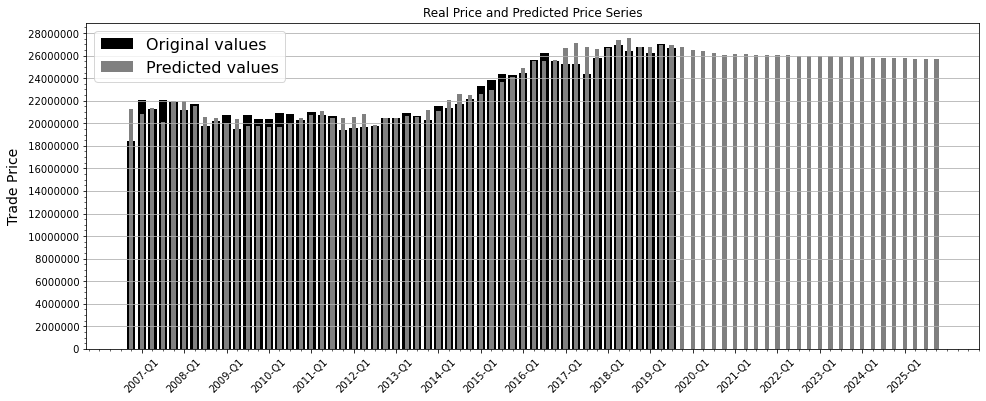

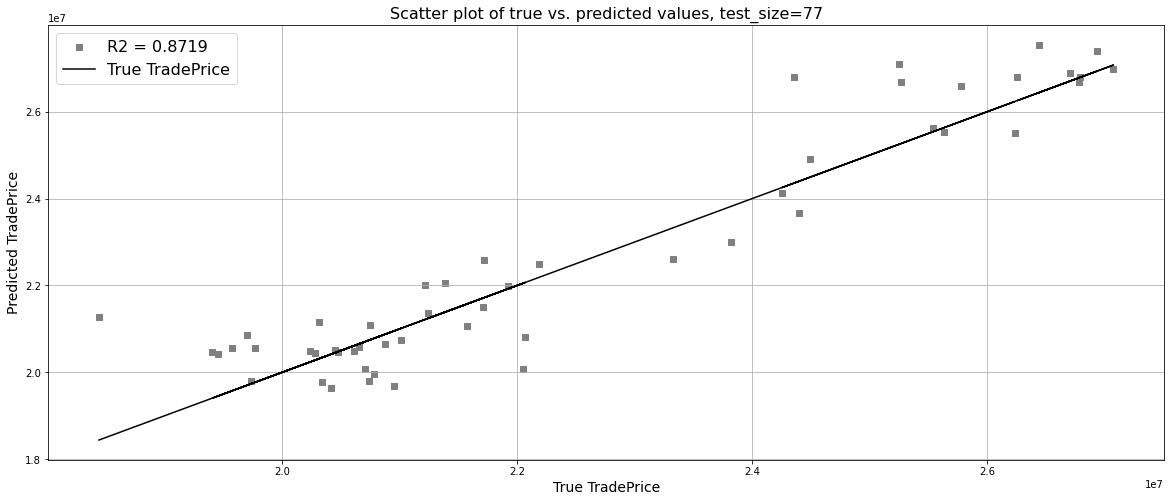

In [ ]:
forecast_summary(time_series, np.concatenate((y_pred_sum[:,0:1],y_future_final[:,0:1])),n_past =n_past,n_future=n_future)


                    ________________________________________________

<a id='Destination_4.2.2'></a>
## Train and Test for all possible X

In [ ]:
def model_kfold(data_folds,kfolds,fold_indecies,scalers):
    
    models = {}
    histories = {}
    test_results = {}

    for k in range(kfolds):

        x_train = data_folds[str(k)]['x_train']
        x_test = data_folds[str(k)]['x_test']
        y_train = data_folds[str(k)]['y_train']
        y_test = data_folds[str(k)]['y_test']

        LSTM_model , history, test_res =  train_test_LSTM(x_train, x_test, y_train, y_test,scalers[str(k)]['SC_y'])
        models[str(k)] = LSTM_model
        histories[str(k)] = history
        test_results[str(k)] = test_res

    return models, histories, test_results

In [ ]:
n_past=5
n_forward=1
kfolds=10

time_series_dict = {}
data_folds_dict = {}
time_seq_data_dict = {}
scalers_dict = {}
fold_indecies_dict = {}
LSTM_model_dict = {}
histories_dict = {}
test_res_dict = {}
test_res_df = pd.DataFrame(columns = ['RMSE','MAE','MAPE'])
models_df = pd.DataFrame(columns = ['Type-CityPlanning'])

for Type in df['Type'].unique():
    
    temp_df = df.loc[df['Type'] == Type]
    
    for CityPlanning in df['CityPlanning'].unique():
        
        temp_df_2 = temp_df.loc[df['CityPlanning'] == CityPlanning]
        
        # take random sample
        if temp_df_2.empty!=True:
            rand_sample = temp_df_2.sample()
            x = pd.Series(rand_sample.values.flatten(),index = rand_sample.columns)
        else:
            continue
        
        # Create Time series
        time_series = create_timeseries(df,x)
        if type(time_series) == pd.core.frame.DataFrame: 
            time_series_dict[Type+'-'+CityPlanning]= time_series

            # Prepare Data 
            data_folds, time_seq_data, scalers, fold_indecies = prepare_data_folds(
                time_series.values[:,:-1],seed=69, n_past=n_past, n_future=n_forward,kfolds=kfolds)
            data_folds_dict[Type+'-'+CityPlanning] = data_folds
            time_seq_data_dict[Type+'-'+CityPlanning] = time_seq_data
            scalers_dict[Type+'-'+CityPlanning] = scalers

            models, histories, test_results = model_kfold(data_folds,kfolds,fold_indecies,scalers)

            LSTM_model_dict[Type+'-'+CityPlanning] = models
            histories_dict[Type+'-'+CityPlanning] = histories
            test_res_dict[Type+'-'+CityPlanning] = test_results
        
            test_res_df_2 = pd.DataFrame(test_results).T.round(4)
            test_res_df = pd.concat([test_res_df,test_res_df_2],axis=0)
            models_df =  pd.concat([models_df,pd.Series(Type+'-'+CityPlanning)],axis=0)
            
            
Test_result_LSTM = np.mean(Test_result_LSTM, axis=0)
test_res_df.to_csv("./LSTM_test_res.csv",index = False)
models_df.to_csv("./LSTM_Tokyo_models_df.csv",index = False)

1/1 [==============================] - 1s 727ms/step


<a id='Destination_5'></a>

## Compare Between Time Series Models 

In [45]:
plot_df = pd.DataFrame(columns = ['Model']+Test_result_ARIMAX.index.to_list()[:-1])
plot_df.loc[:,'Model'] = ['ARIMAX','SARIMAX','LSTM']
plot_df.loc[:,'RMSE'] = [Test_result_ARIMAX['RMSE'],Test_result_SARIMAX['RMSE'],Test_result_LSTM['RMSE']]
plot_df.loc[:,'MAE'] = [Test_result_ARIMAX['MAE'],Test_result_SARIMAX['MAE'],Test_result_LSTM['MAE']]
plot_df.loc[:,'MAPE'] = [Test_result_ARIMAX['MAPE_inverse'],Test_result_SARIMAX['MAPE_inverse'],Test_result_LSTM['MAPE']]
plot_df

,Model,RMSE,MAE,MAPE
0,ARIMAX,0.202831,0.173983,0.158707
1,SARIMAX,0.284819,0.253633,0.257552
2,LSTM,0.223651,0.192025,0.200020


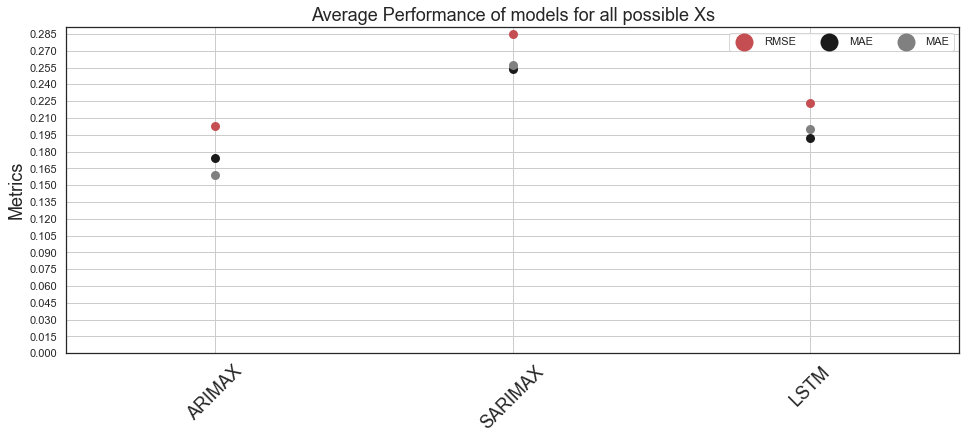

In [61]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.swarmplot(x="Model", y='RMSE', data=plot_df, color = 'r',label='RMSE',size=9)
sns.swarmplot(x="Model", y='MAE', data=plot_df, color = 'k',label='MAE',size=9)
sns.swarmplot(x="Model", y='MAPE', data=plot_df, color = 'gray',label='MAE',size=9)
ax.set_title('Average Performance of models for all possible Xs',fontsize=18)
ax.set_ylabel('Metrics',fontsize=18)
ax.set_xlabel('')
ax.yaxis.set_major_locator(MultipleLocator(0.015))
ax.tick_params(axis='x', which='major', labelsize=18)
plt.ylim(0)
plt.xticks(rotation=45)
plt.grid()
handles, labels = ax.get_legend_handles_labels()
handles = [handles[2],handles[4],handles[-1]]
labels = [labels[2],labels[4],labels[-1]]
ax.legend(handles, labels,markerscale=2,ncol=3)
plt.show()